In [31]:
import numpy as np #
import pandas as pd 
import  matplotlib.pyplot  as  plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
for dirname, _, filenames in os.walk('/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [32]:
### read the data
df   =  pd.read_csv('./data/Sales_WeeklyCoalPrice.csv')
df.head()

,Date,Coal_Type,Benchmark,Per _Price
0,2019-01-07,HCC,GM EXW #5 Jinquan,1160.0
1,2019-01-07,HCC,GM EXW #3,0.0
2,2019-01-07,HCC,Baotou EXW,1092.0
3,2019-01-07,HCC,Tangshan Hebei FOR,1635.0
4,2019-01-07,HCC,Jingtang Australia EXW,1670.0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2680 entries, 0 to 2679
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2680 non-null   object 
 1   Coal_Type   2680 non-null   object 
 2   Benchmark   2680 non-null   object 
 3   Per _Price  2680 non-null   float64
dtypes: float64(1), object(3)
memory usage: 83.9+ KB


In [34]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'
      .format(df.isnull().values.sum()))

temp_energy = df.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 0 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [35]:
#get items by Benchmark

benchmarks = df['Benchmark'].unique()
len(benchmarks)

8

In [36]:
#get coal type by Coal_Type

coal_types = df['Coal_Type'].unique()
coal_types

array(['HCC', 'SSCC', 'TC'], dtype=object)

In [37]:
df.head()

,Date,Coal_Type,Benchmark,Per _Price
0,2019-01-07,HCC,GM EXW #5 Jinquan,1160.0
1,2019-01-07,HCC,GM EXW #3,0.0
2,2019-01-07,HCC,Baotou EXW,1092.0
3,2019-01-07,HCC,Tangshan Hebei FOR,1635.0
4,2019-01-07,HCC,Jingtang Australia EXW,1670.0


In [38]:
#dict by benchmark

benchmarks_dict = {}

cnt = 1
for benchmark in benchmarks:
  coal_types_dict = {}
  for coal_type in coal_types:
     
    cnt+=1
    
    #generate data here
    cond1 = df['Benchmark'] == benchmark
    cond2 = df['Coal_Type'] == coal_type
    data = df.where(
      cond1 & cond2
    )
    #clear nan
    
    data = data.dropna()
    data = data[['Date', 'Per _Price']]
    data['Date'] = pd.to_datetime(data['Date'], utc=True, infer_datetime_format=True)
    coal_types_dict[coal_type] =data
    
  benchmarks_dict[benchmark] = coal_types_dict
  #clear coal_types_dict 
  coal_types_dict = {}
  
  
print(benchmarks_dict)
# print(benchmarks_dict['GM EXW #5 Jinquan '].head()) 

{'GM EXW #5 Jinquan ': {'HCC':                           Date  Per _Price
0    2019-01-07 00:00:00+00:00      1160.0
10   2019-01-14 00:00:00+00:00      1160.0
20   2019-01-21 00:00:00+00:00      1160.0
30   2019-01-28 00:00:00+00:00      1160.0
40   2019-02-04 00:00:00+00:00      1160.0
...                        ...         ...
2630 2024-01-29 00:00:00+00:00      1850.0
2640 2024-02-05 00:00:00+00:00      1800.0
2650 2024-02-12 00:00:00+00:00      1800.0
2660 2024-02-19 00:00:00+00:00      1800.0
2670 2024-02-26 00:00:00+00:00      1800.0

[268 rows x 2 columns], 'SSCC': Empty DataFrame
Columns: [Date, Per _Price]
Index: [], 'TC': Empty DataFrame
Columns: [Date, Per _Price]
Index: []}, 'GM EXW #3': {'HCC':                           Date  Per _Price
1    2019-01-07 00:00:00+00:00         0.0
11   2019-01-14 00:00:00+00:00         0.0
21   2019-01-21 00:00:00+00:00         0.0
31   2019-01-28 00:00:00+00:00         0.0
41   2019-02-04 00:00:00+00:00         0.0
...                     

/var/folders/6y/6q90_6fx451bhd6kbn9ly_f40000gn/T/ipykernel_29697/1052514399.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['Date'] = pd.to_datetime(data['Date'], utc=True, infer_datetime_format=True)
/var/folders/6y/6q90_6fx451bhd6kbn9ly_f40000gn/T/ipykernel_29697/1052514399.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['Date'] = pd.to_datetime(data['Date'], utc=True, infer_datetime_format=True)
/var/folders/6y/6q90_6fx451bhd6kbn9ly_f40000gn/T/ipykernel_29697/1052514399.py:22: UserWarning: The argument 'infer_datetime_format' is depr

In [39]:
import seaborn as sns
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Date', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax




GM EXW #5 Jinquan 
HCC


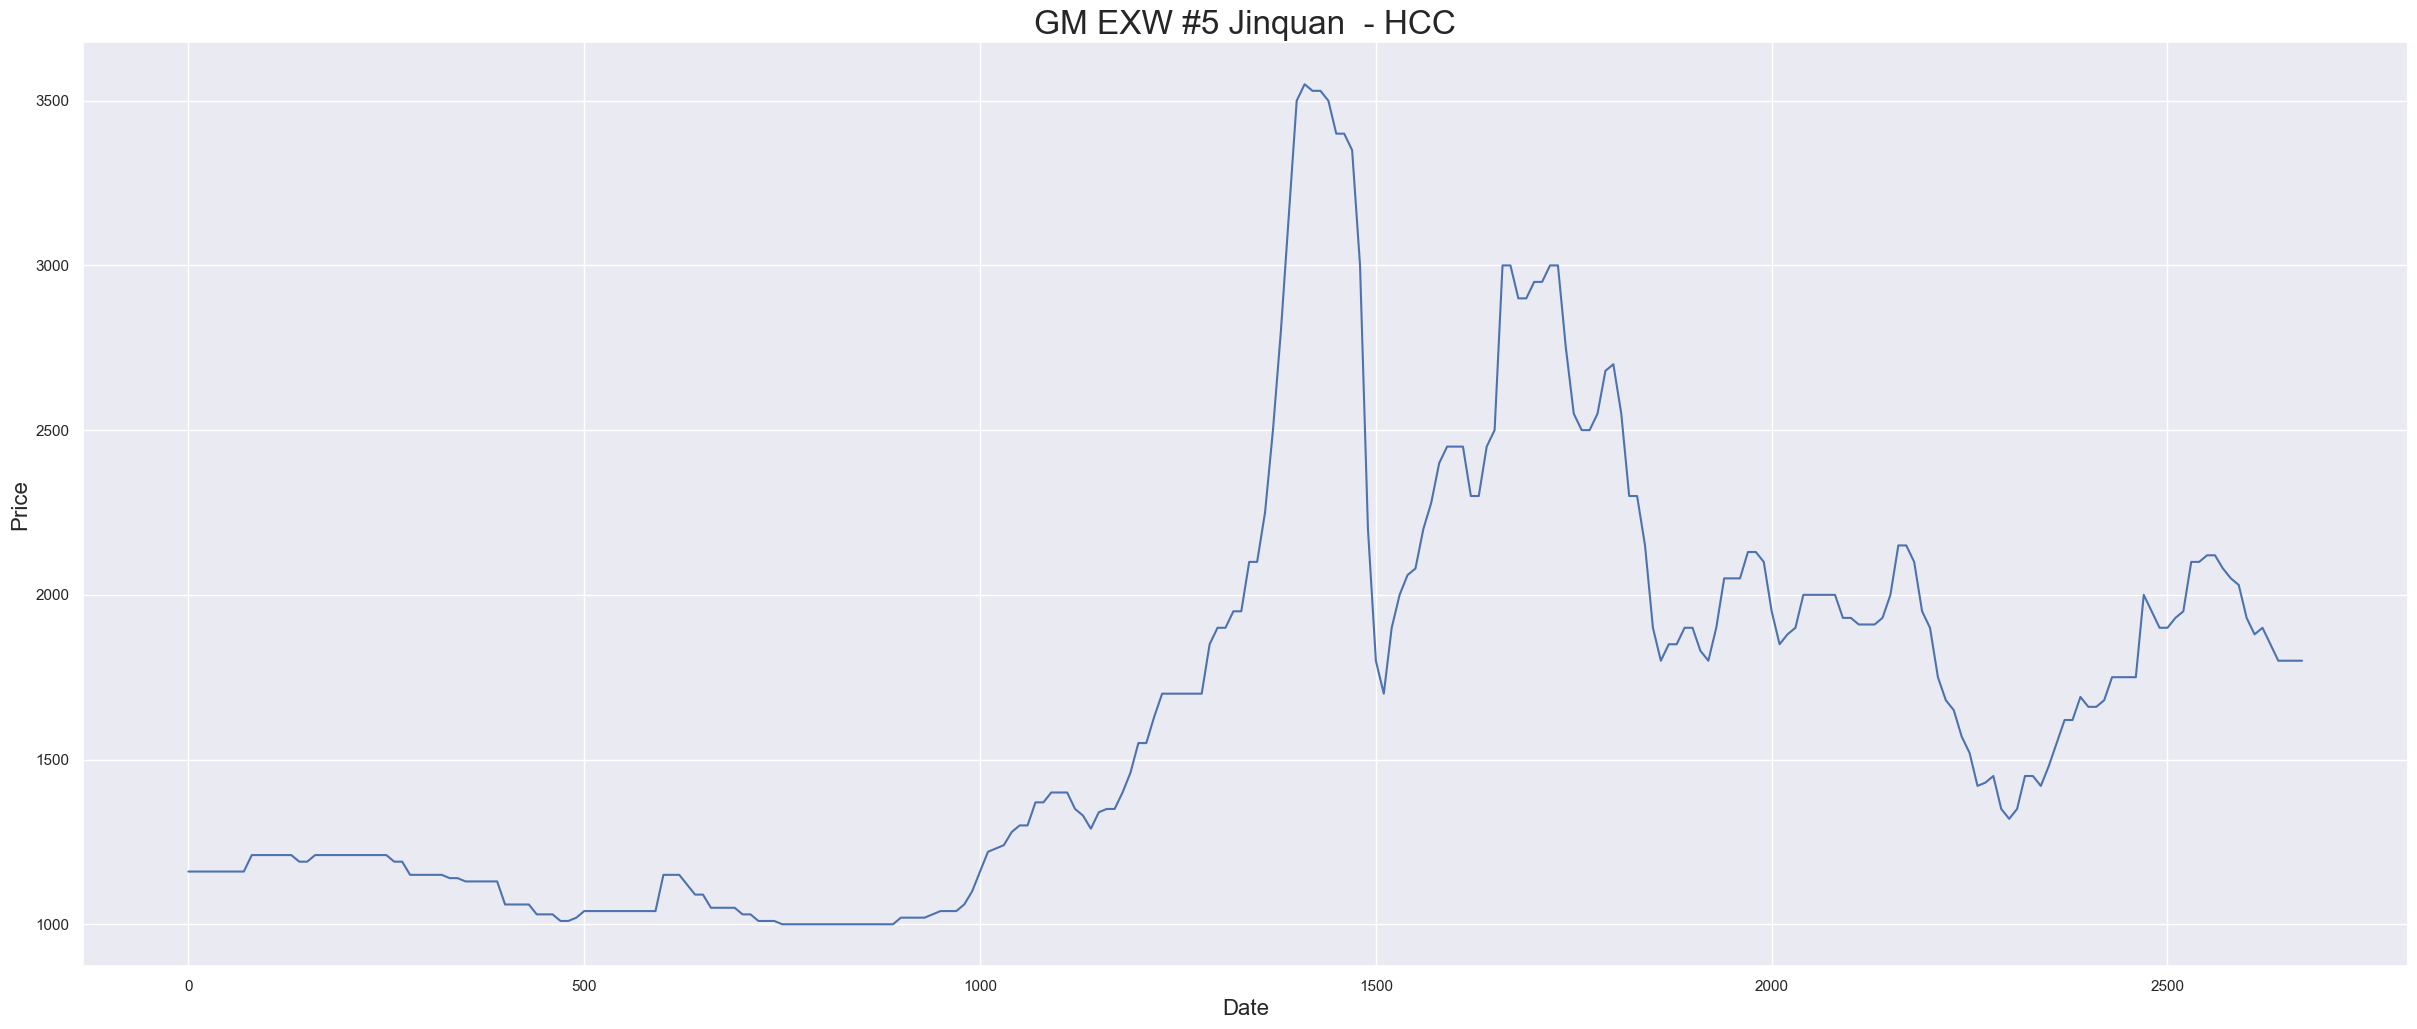

SSCC


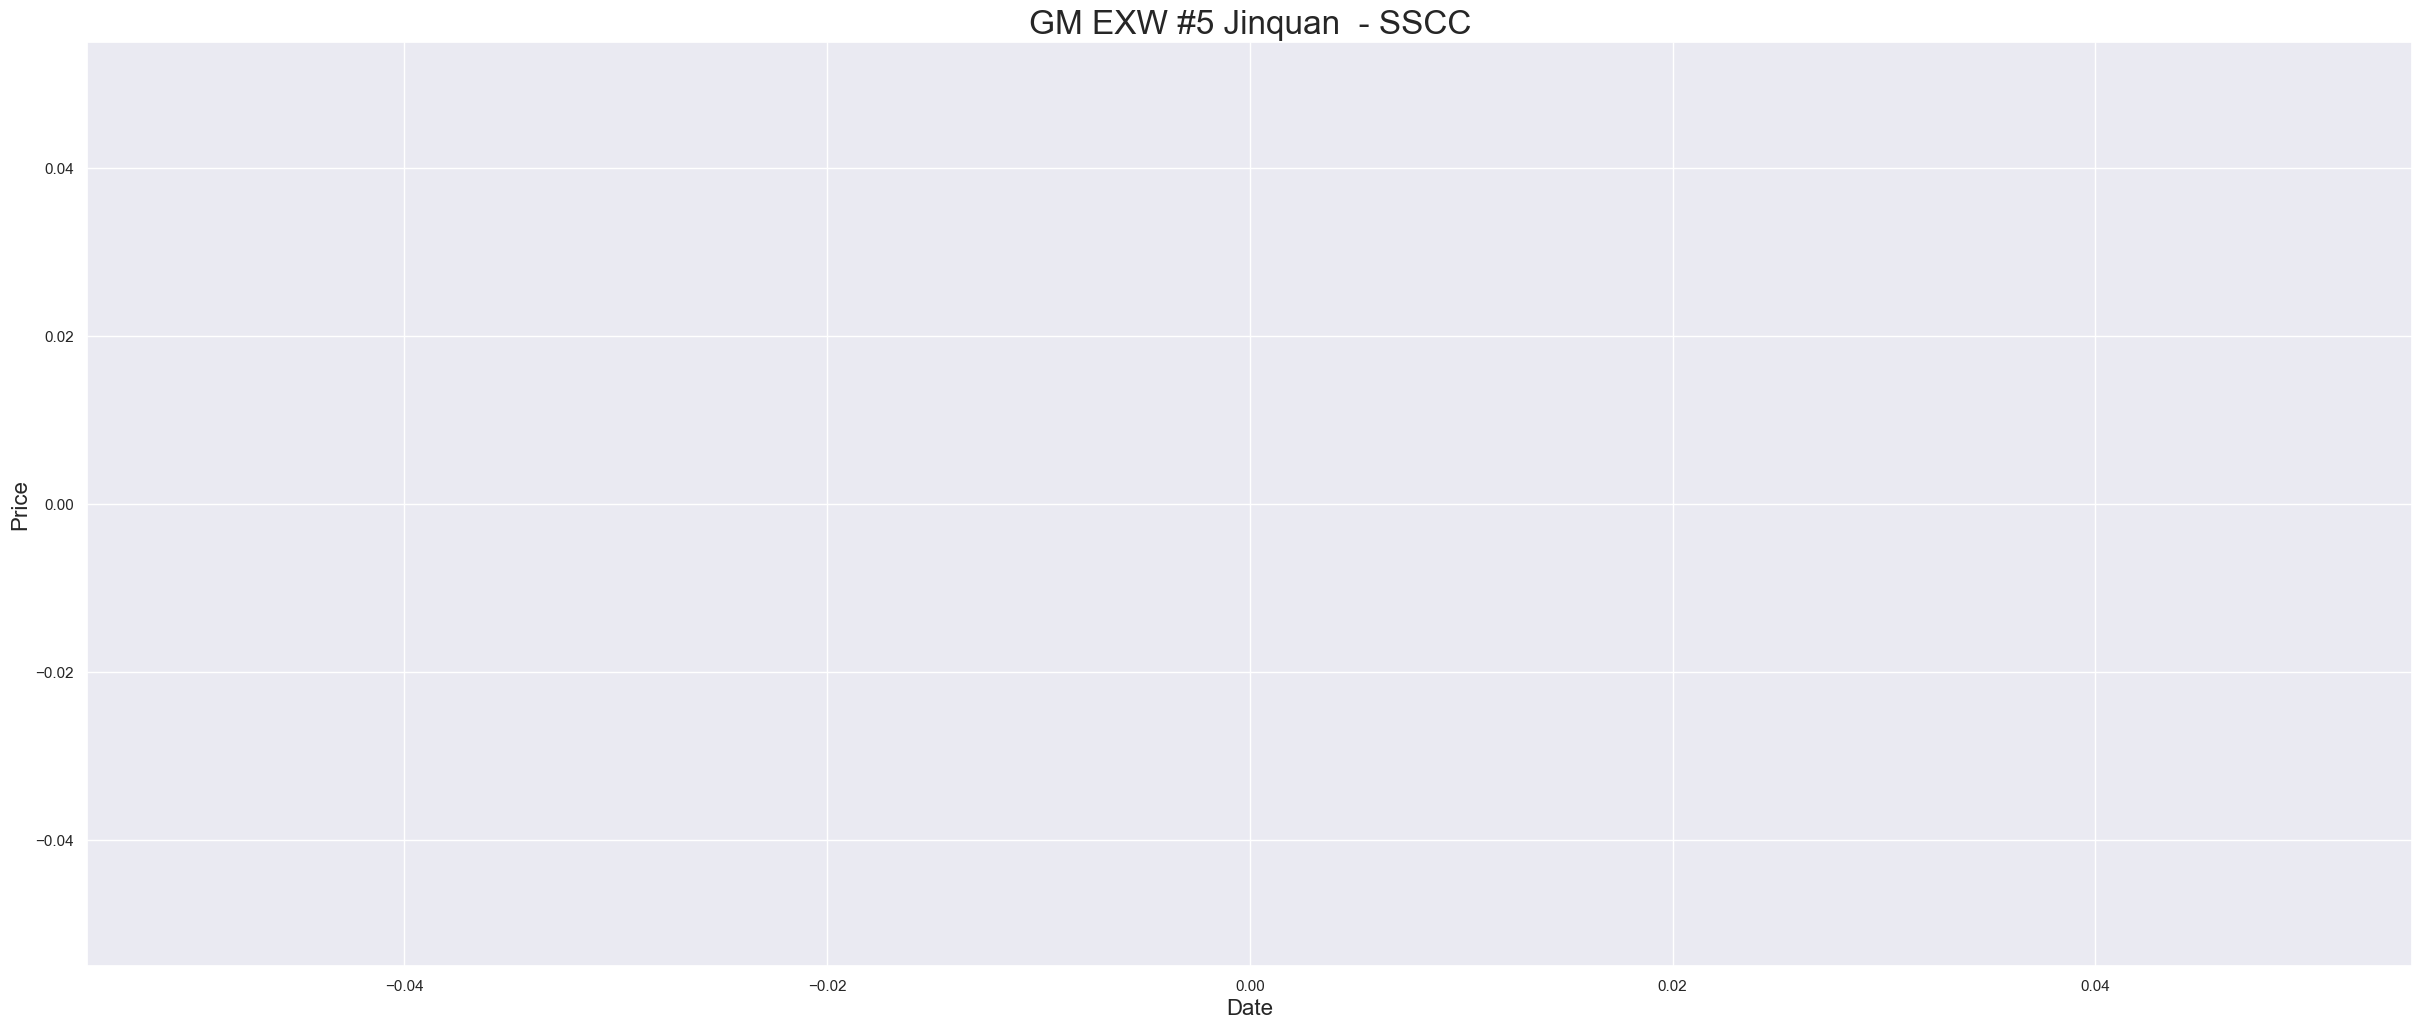

TC


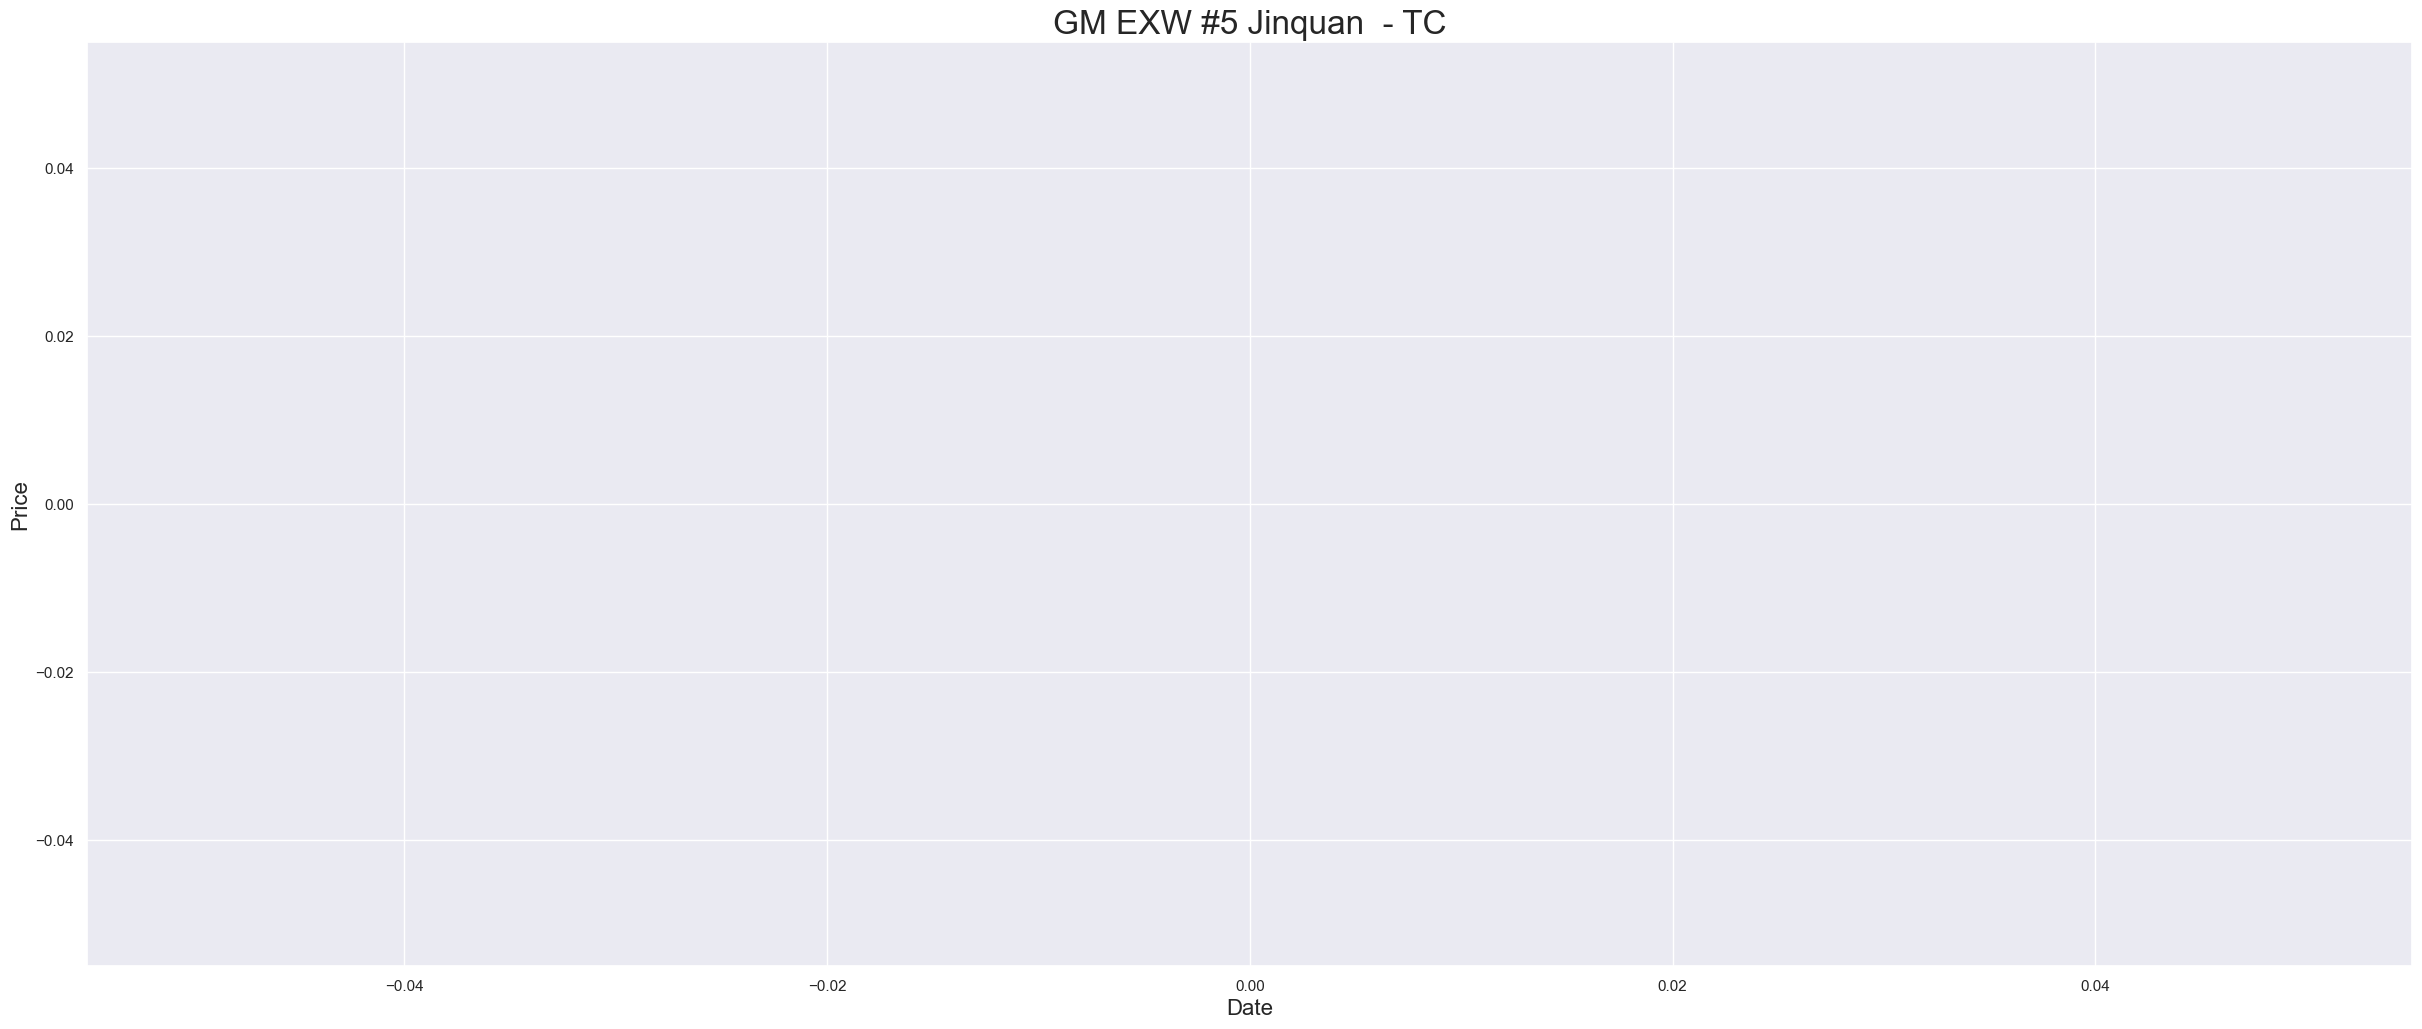

GM EXW #3
HCC


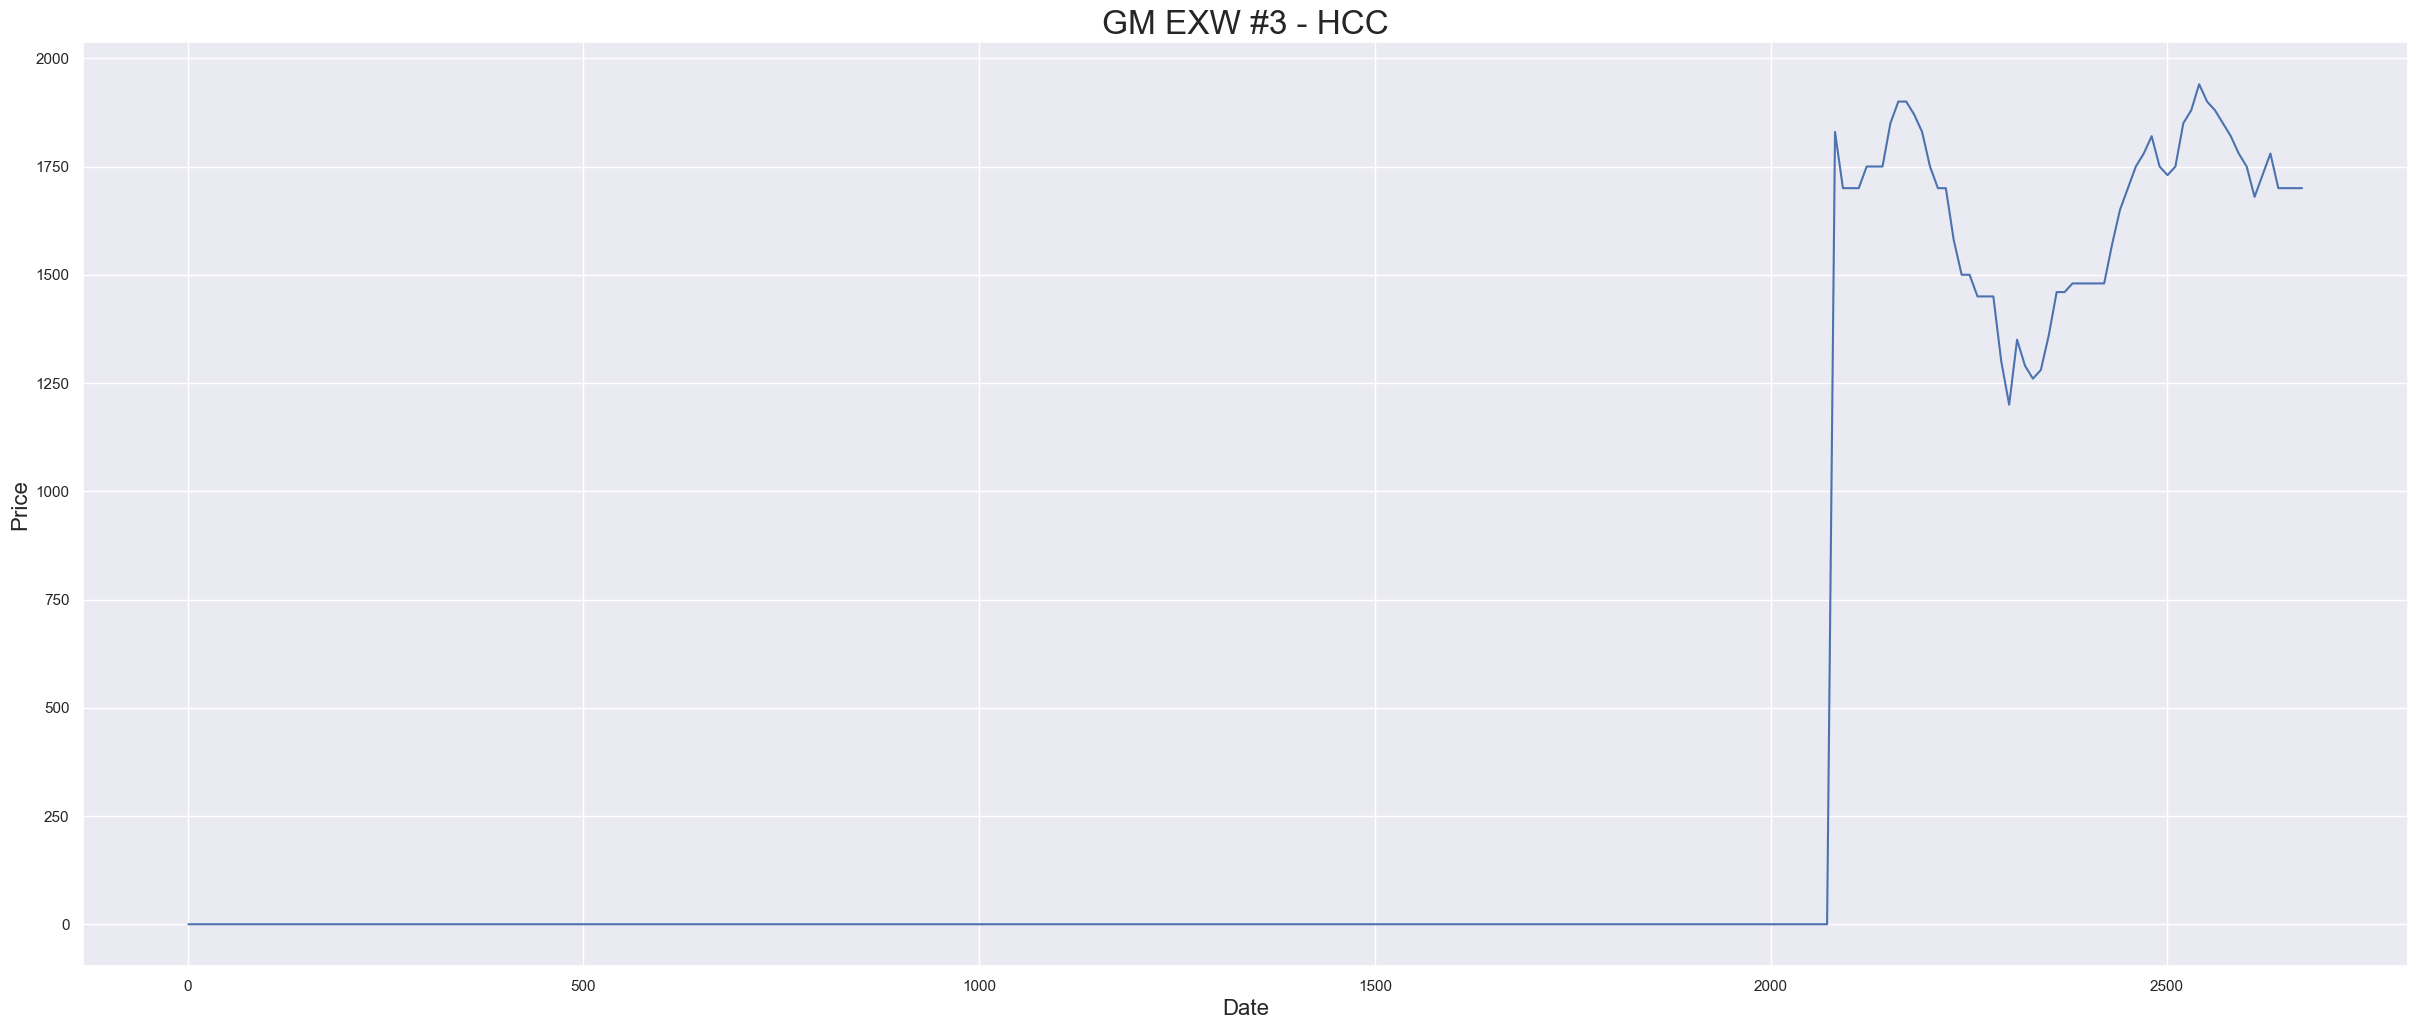

SSCC


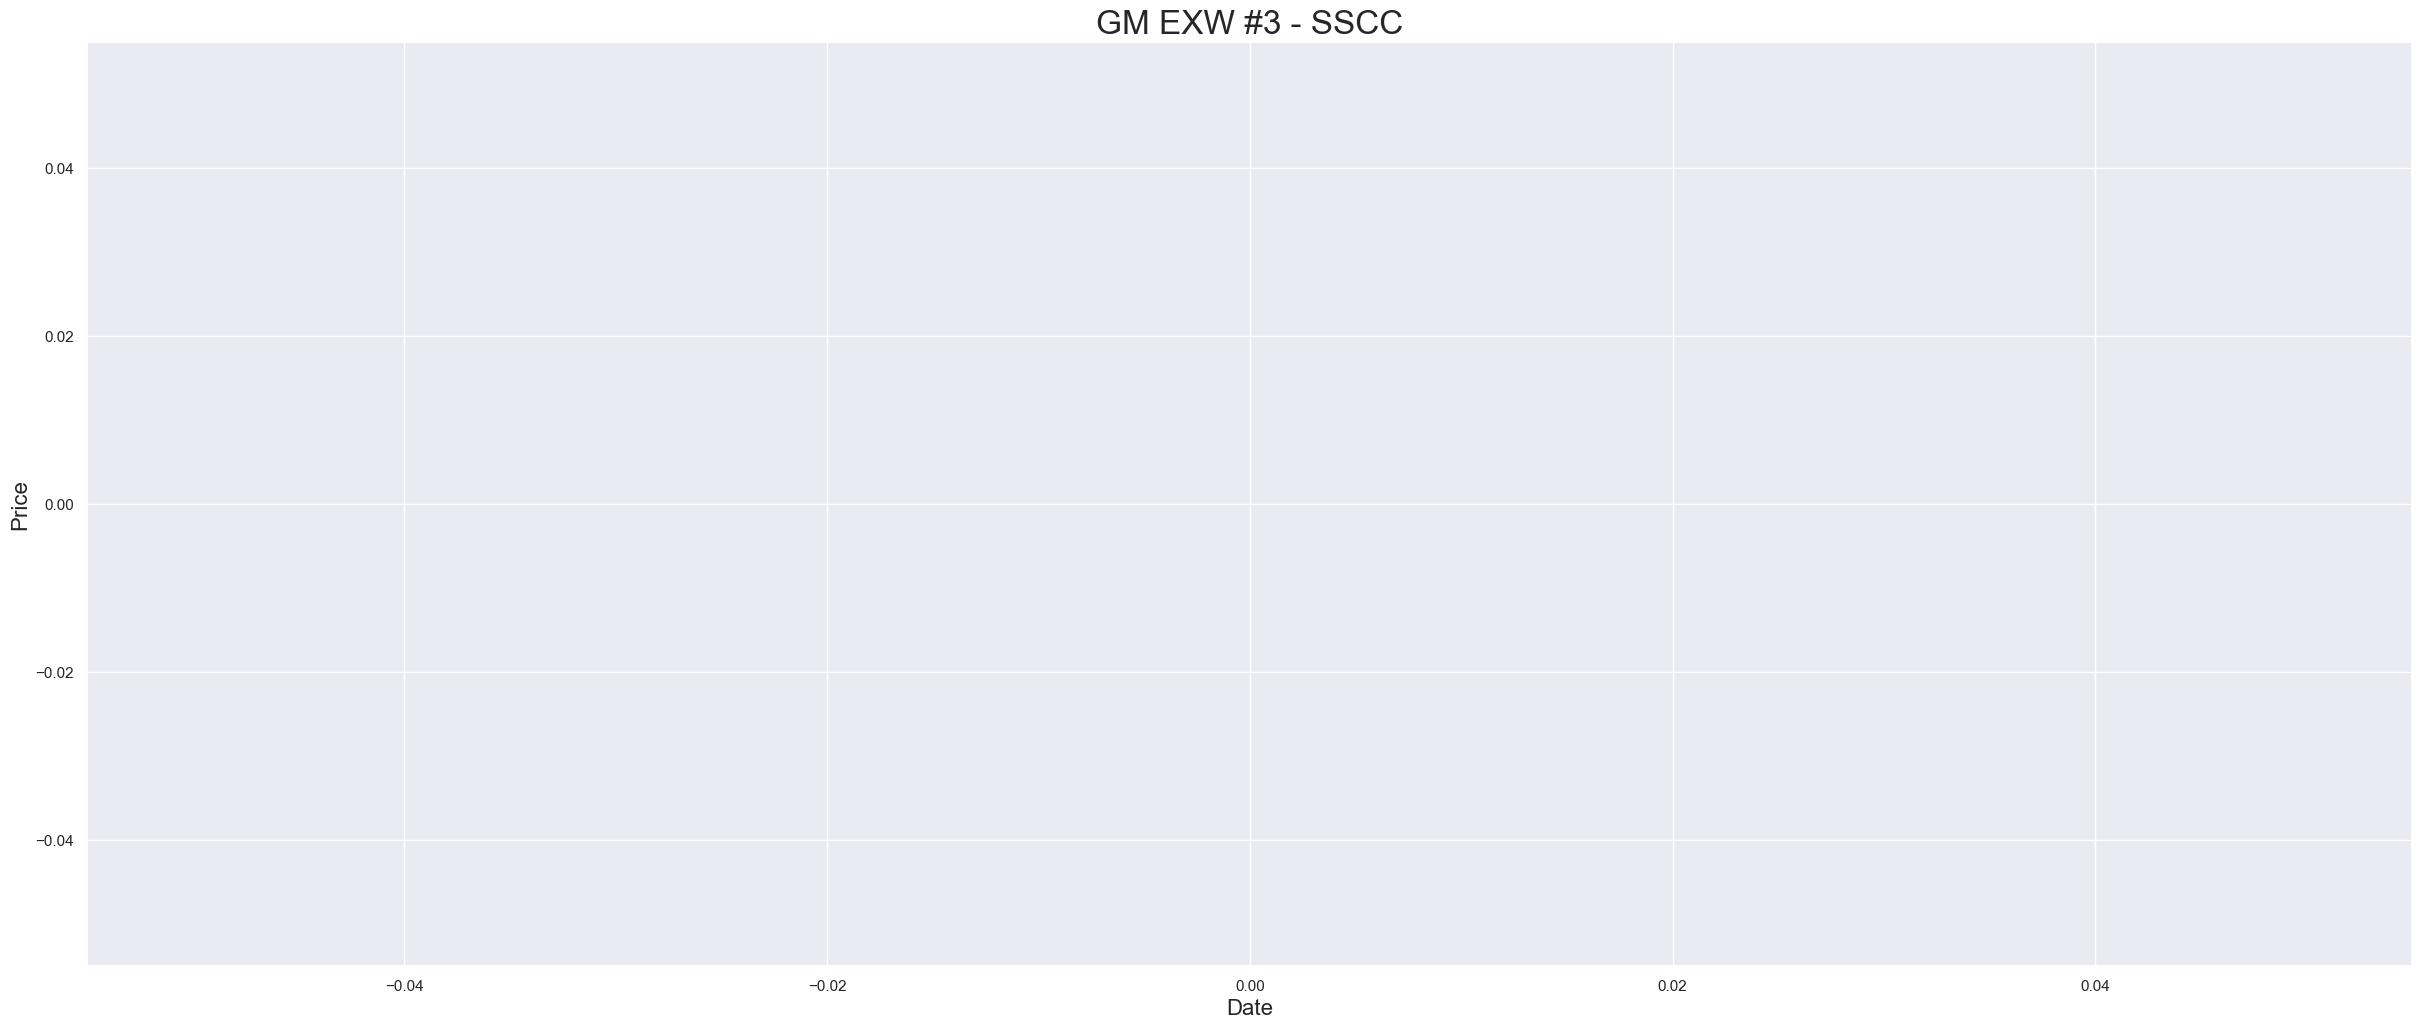

TC


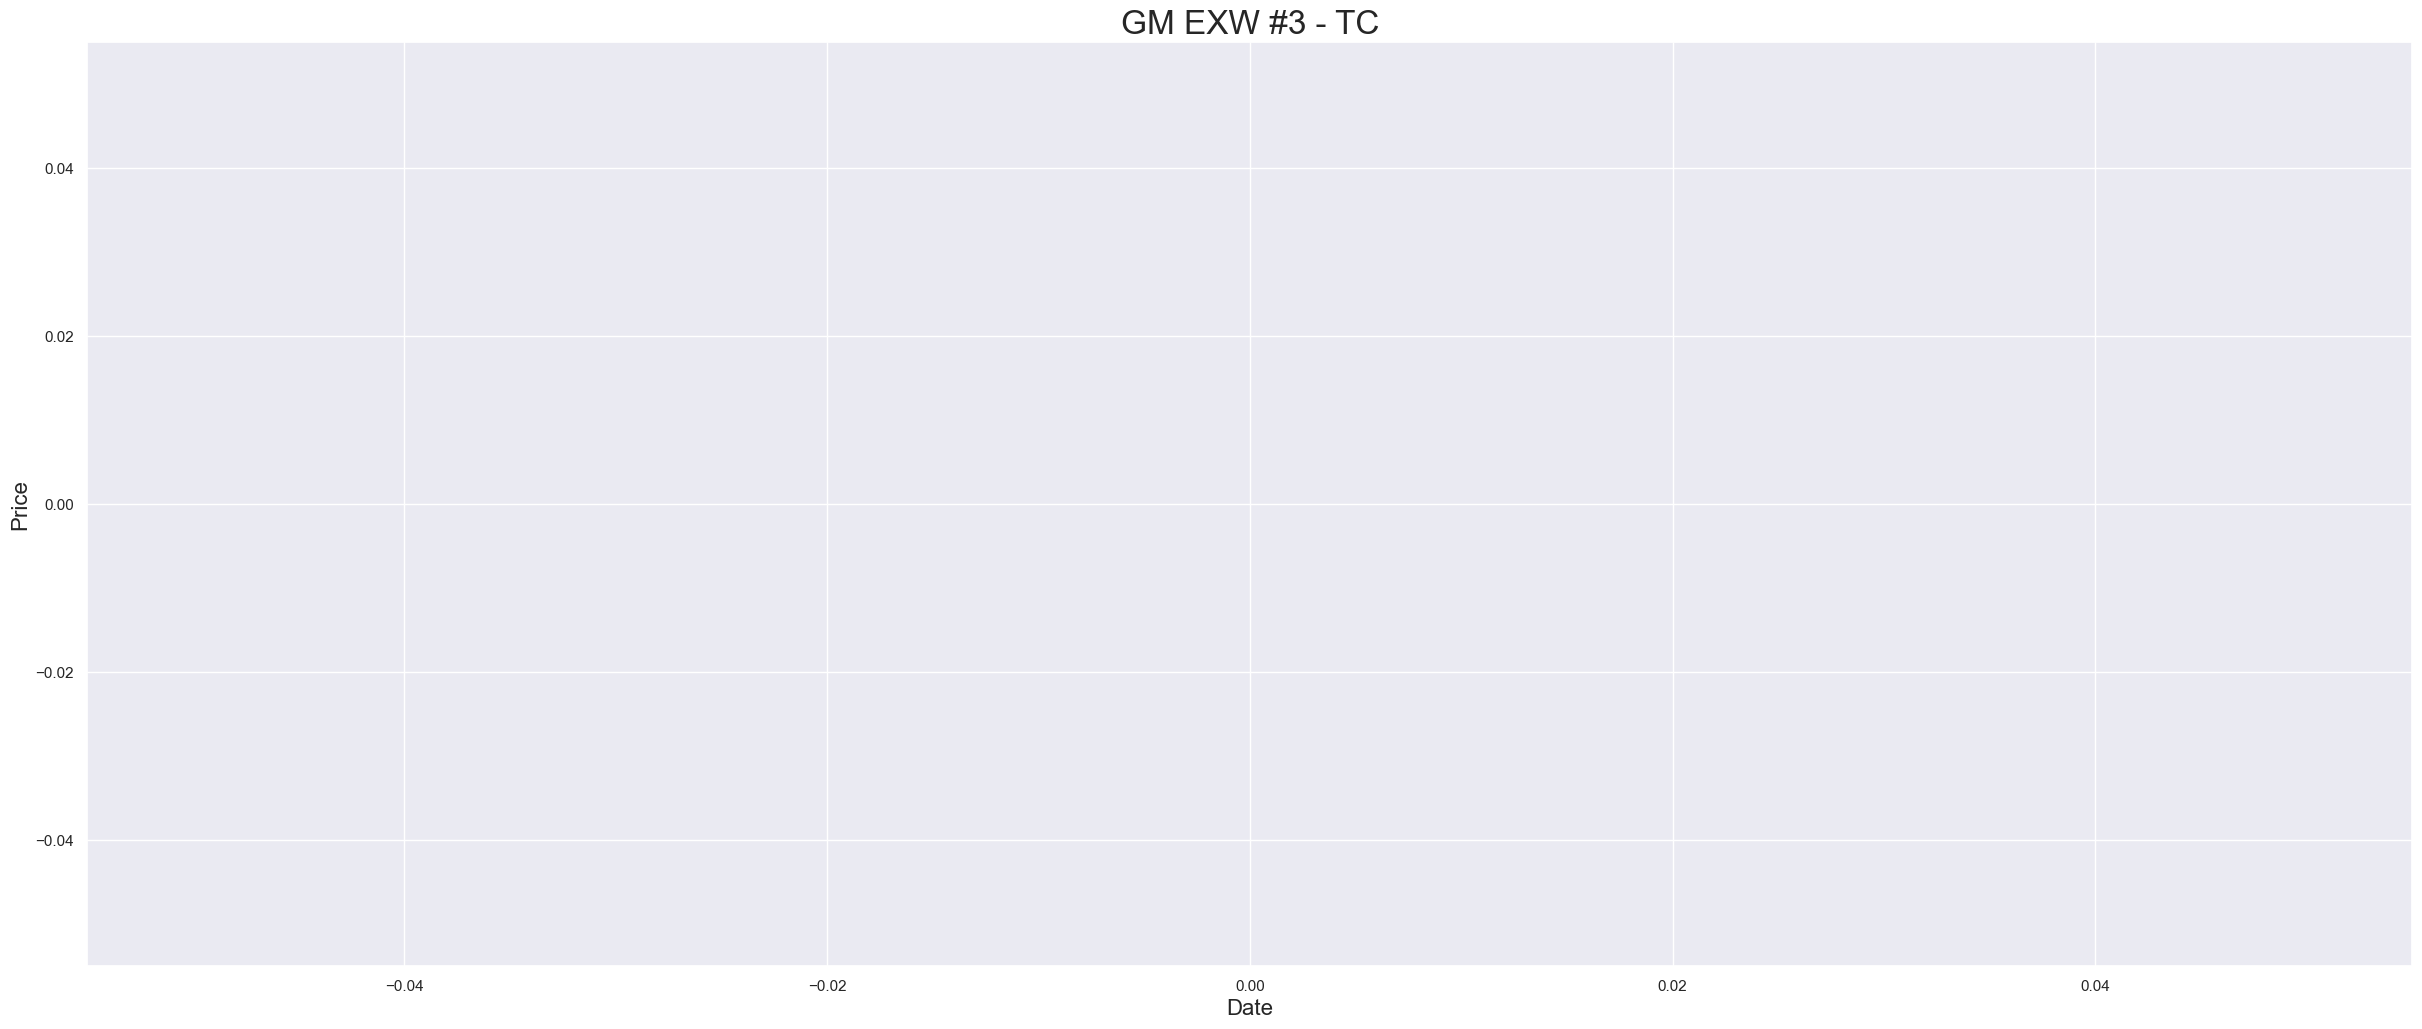

Baotou EXW
HCC


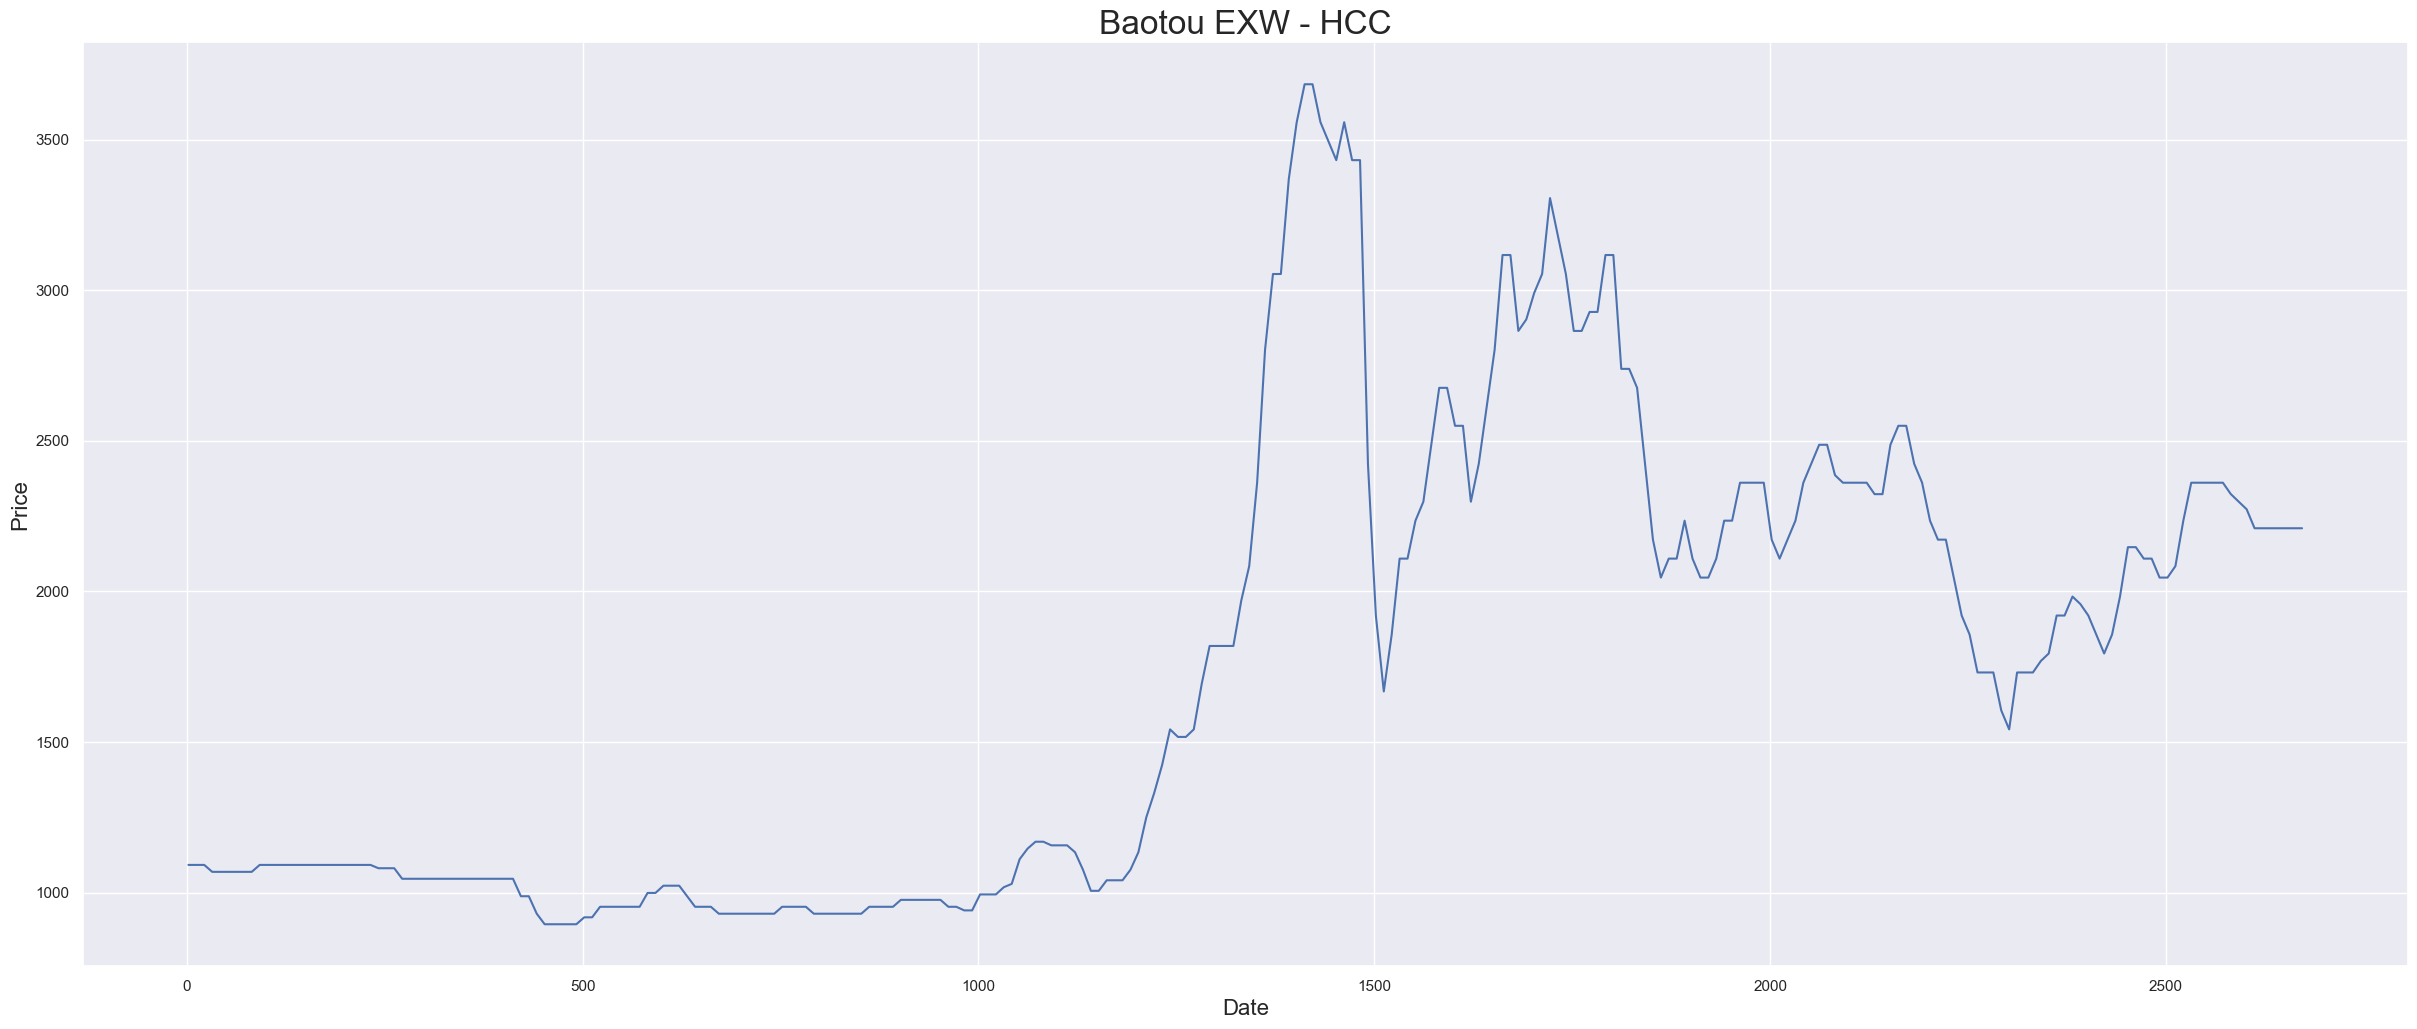

SSCC


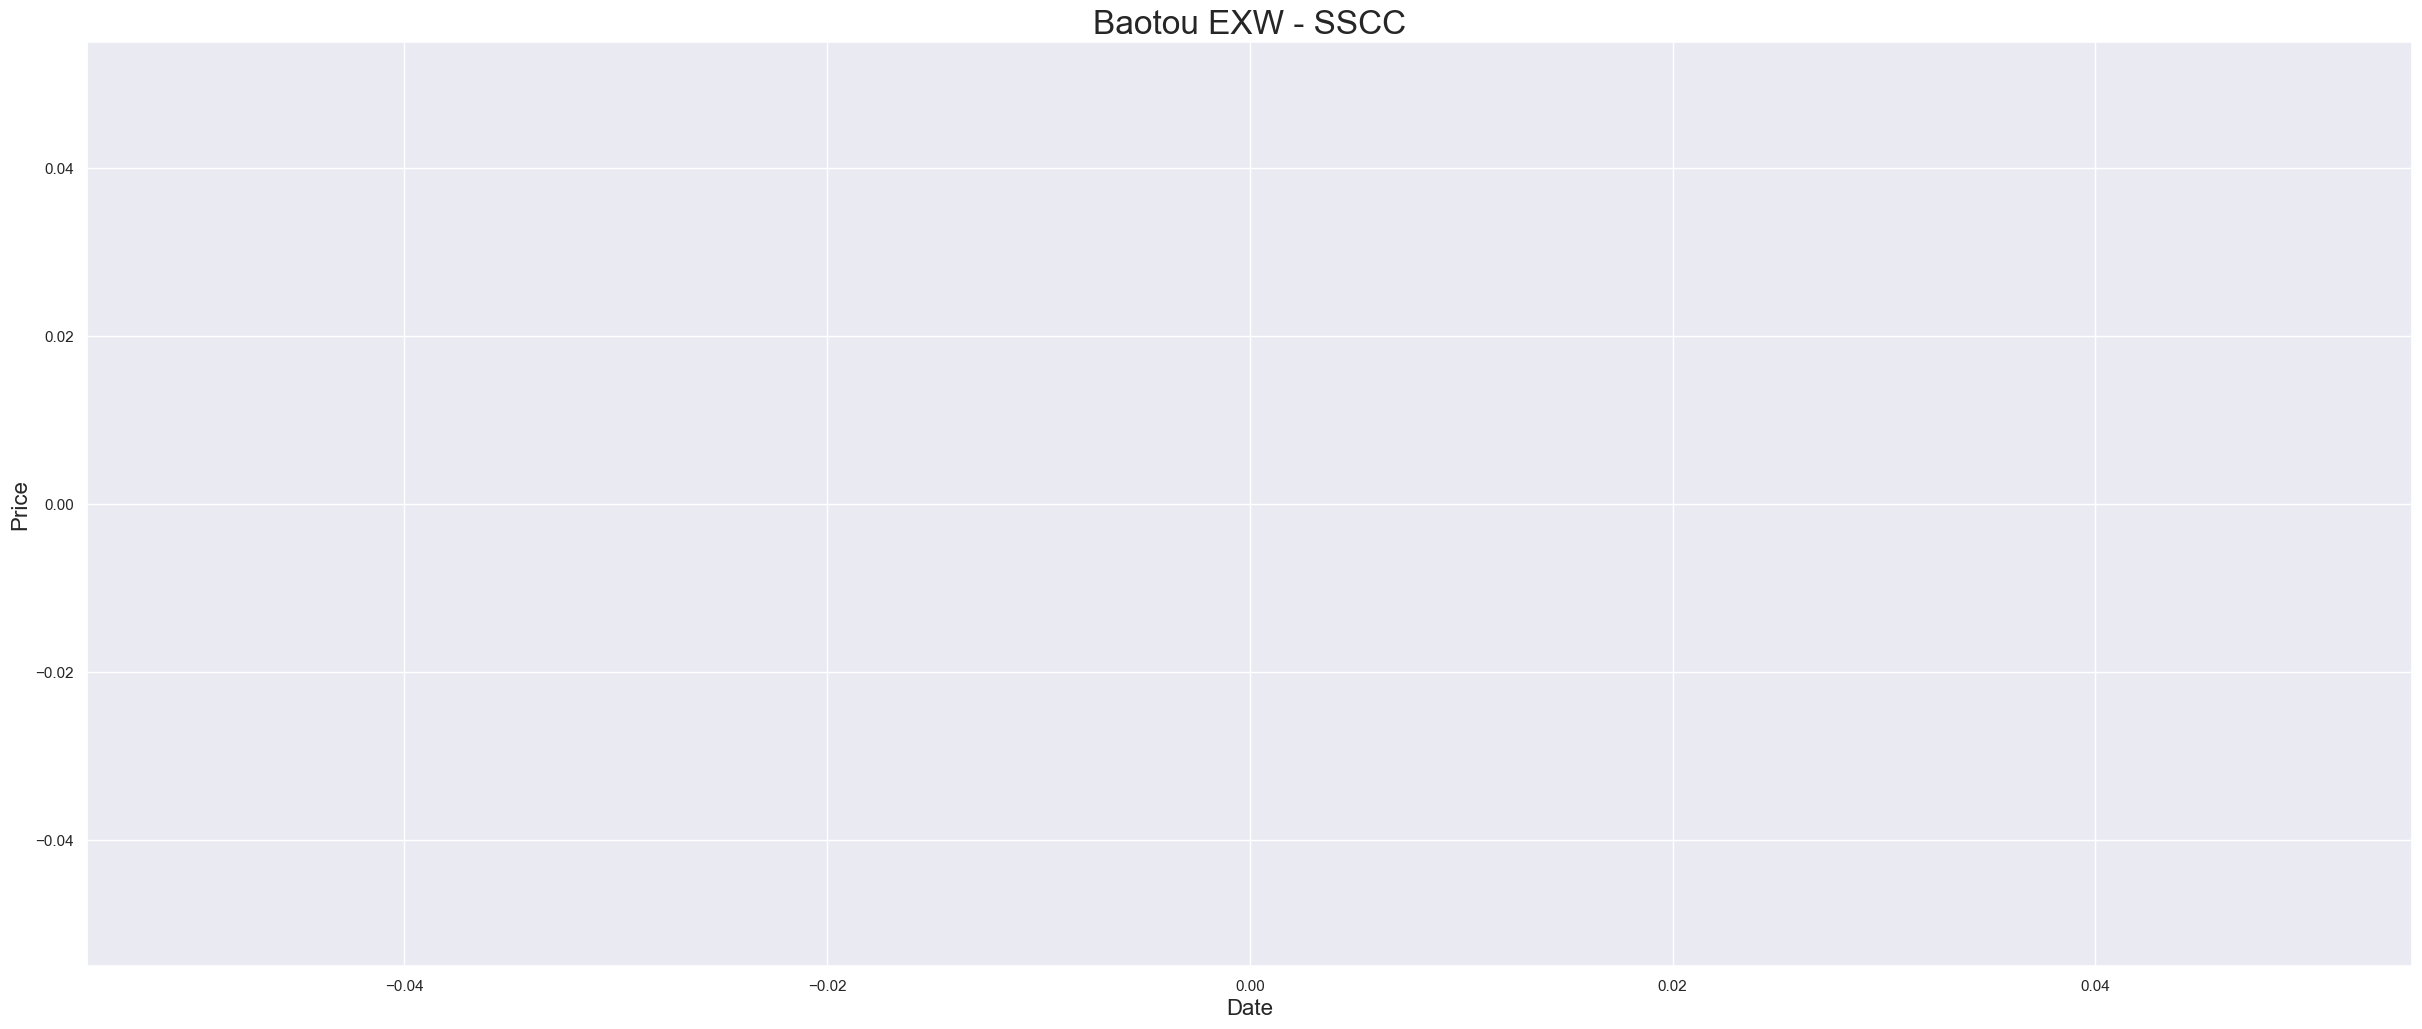

TC


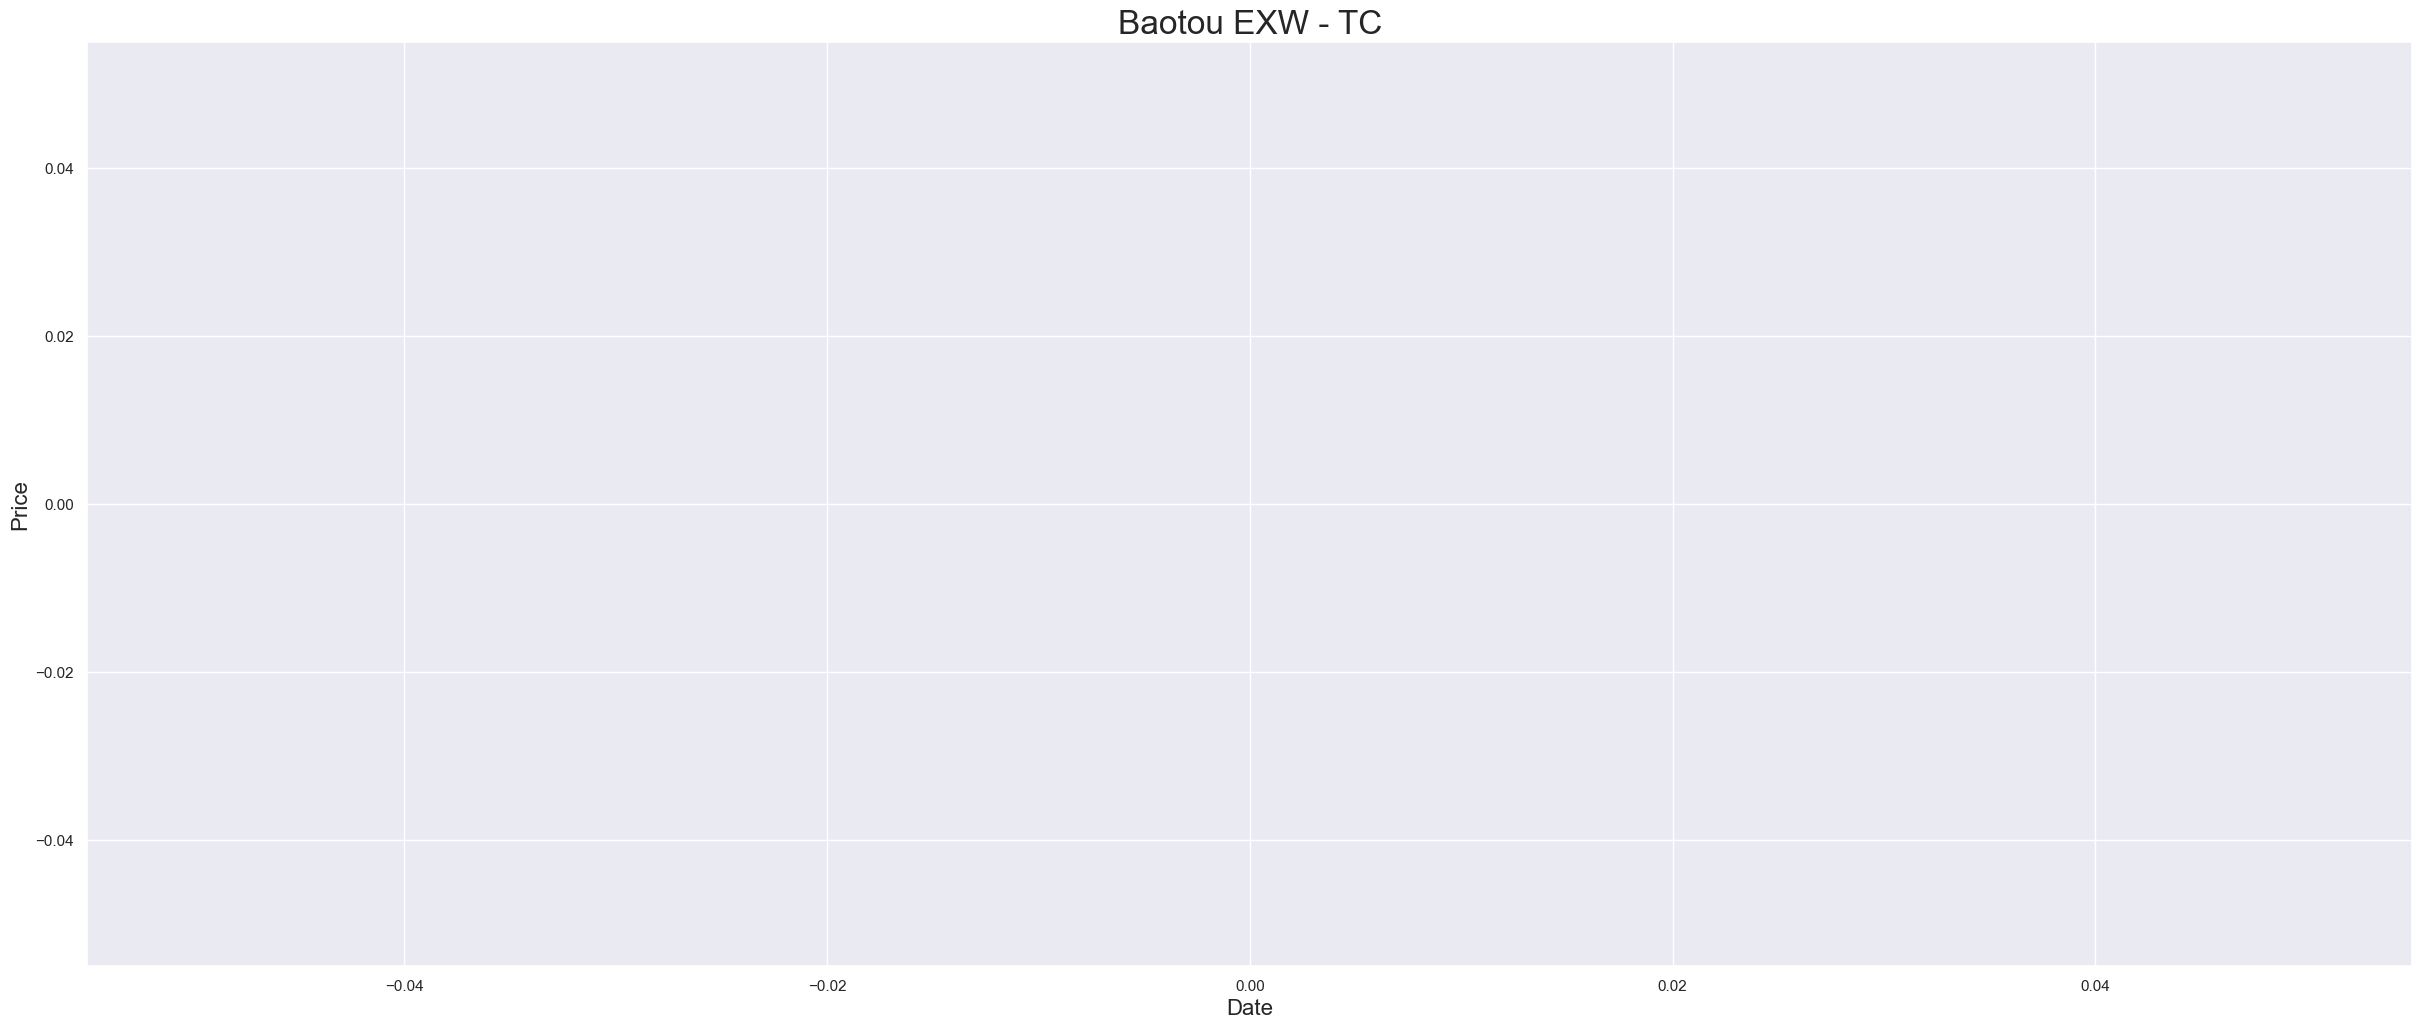

Tangshan Hebei FOR
HCC


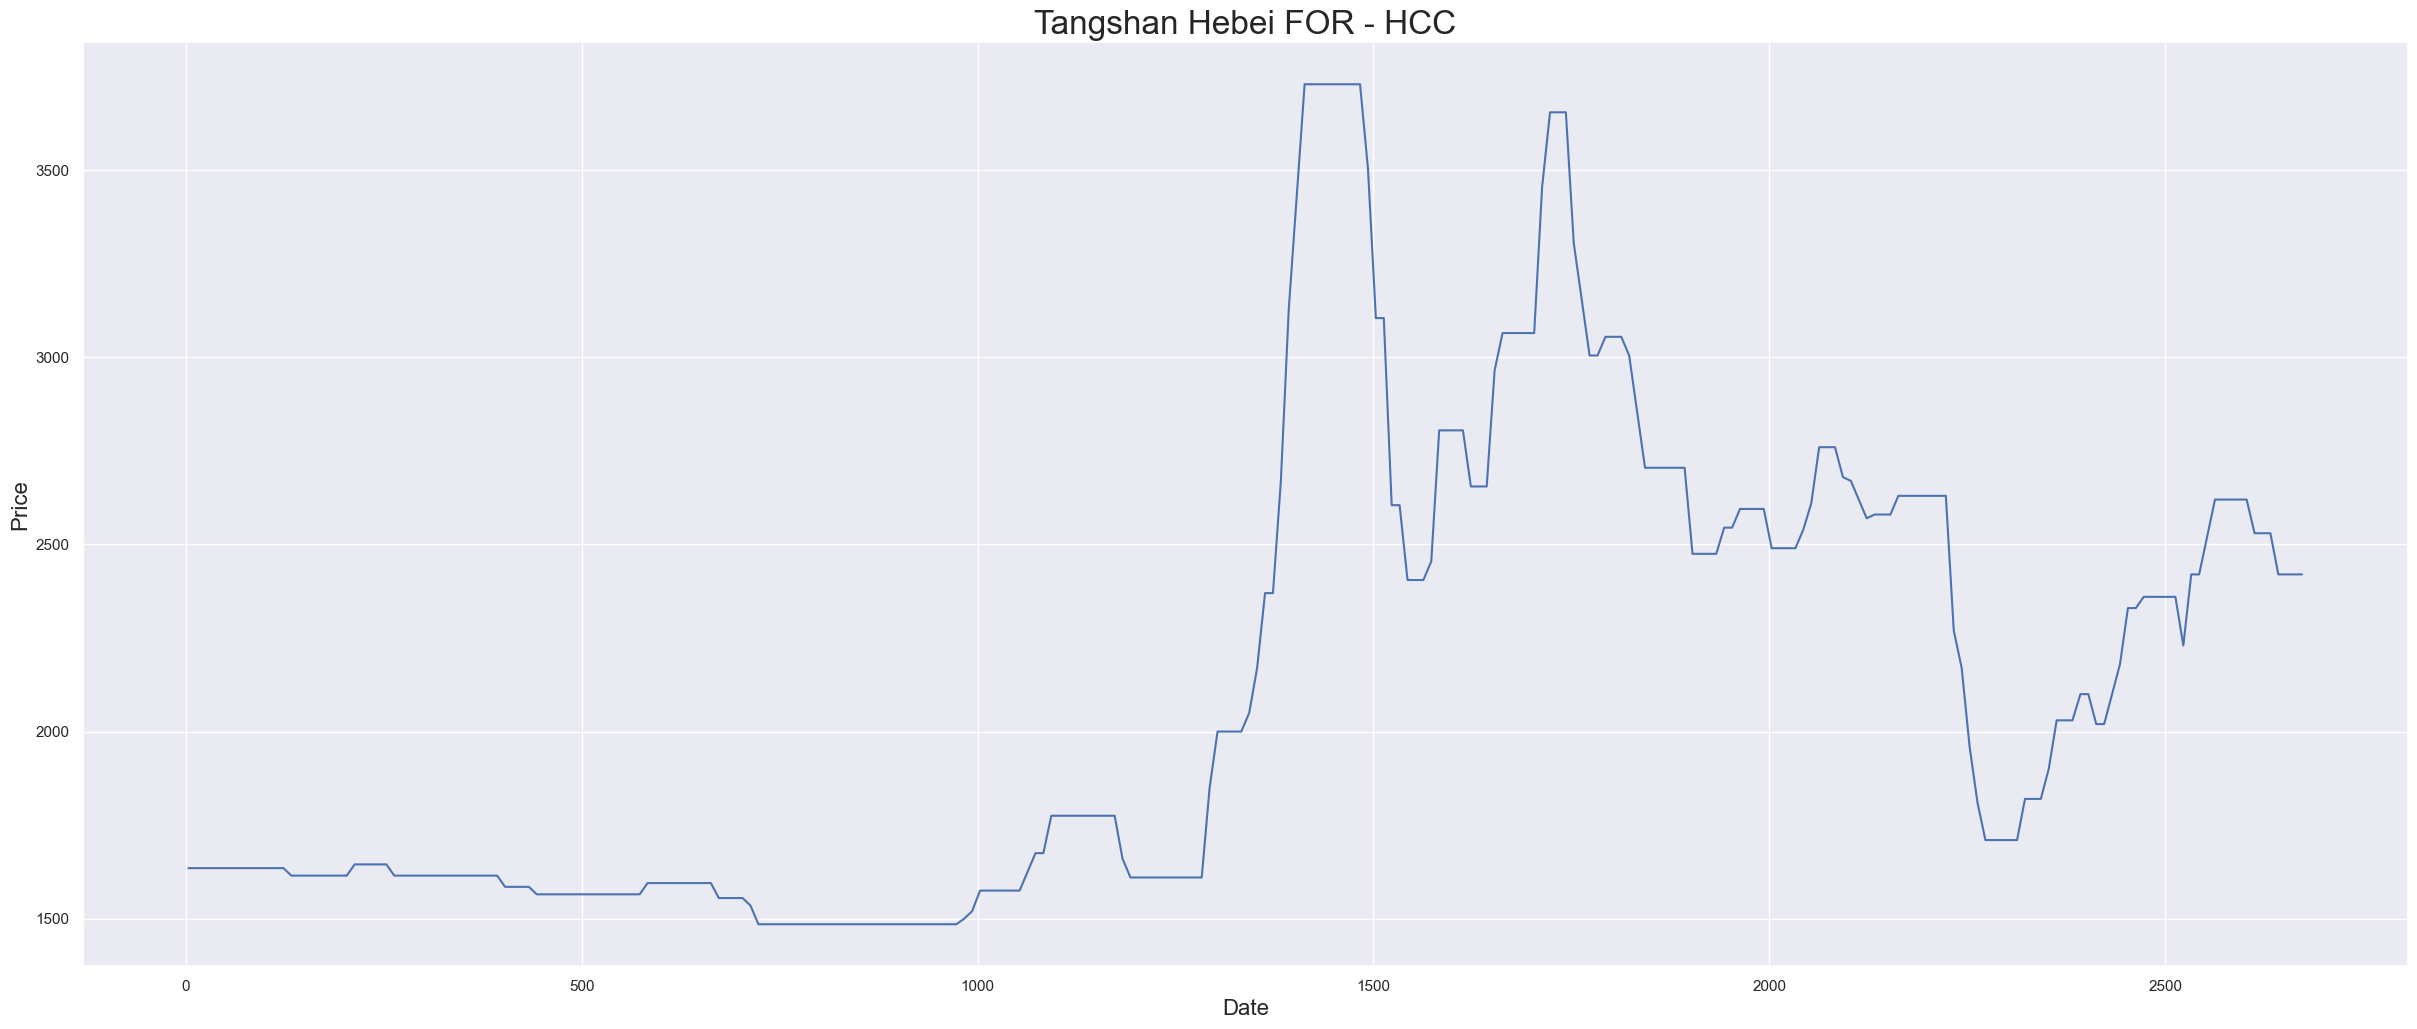

SSCC


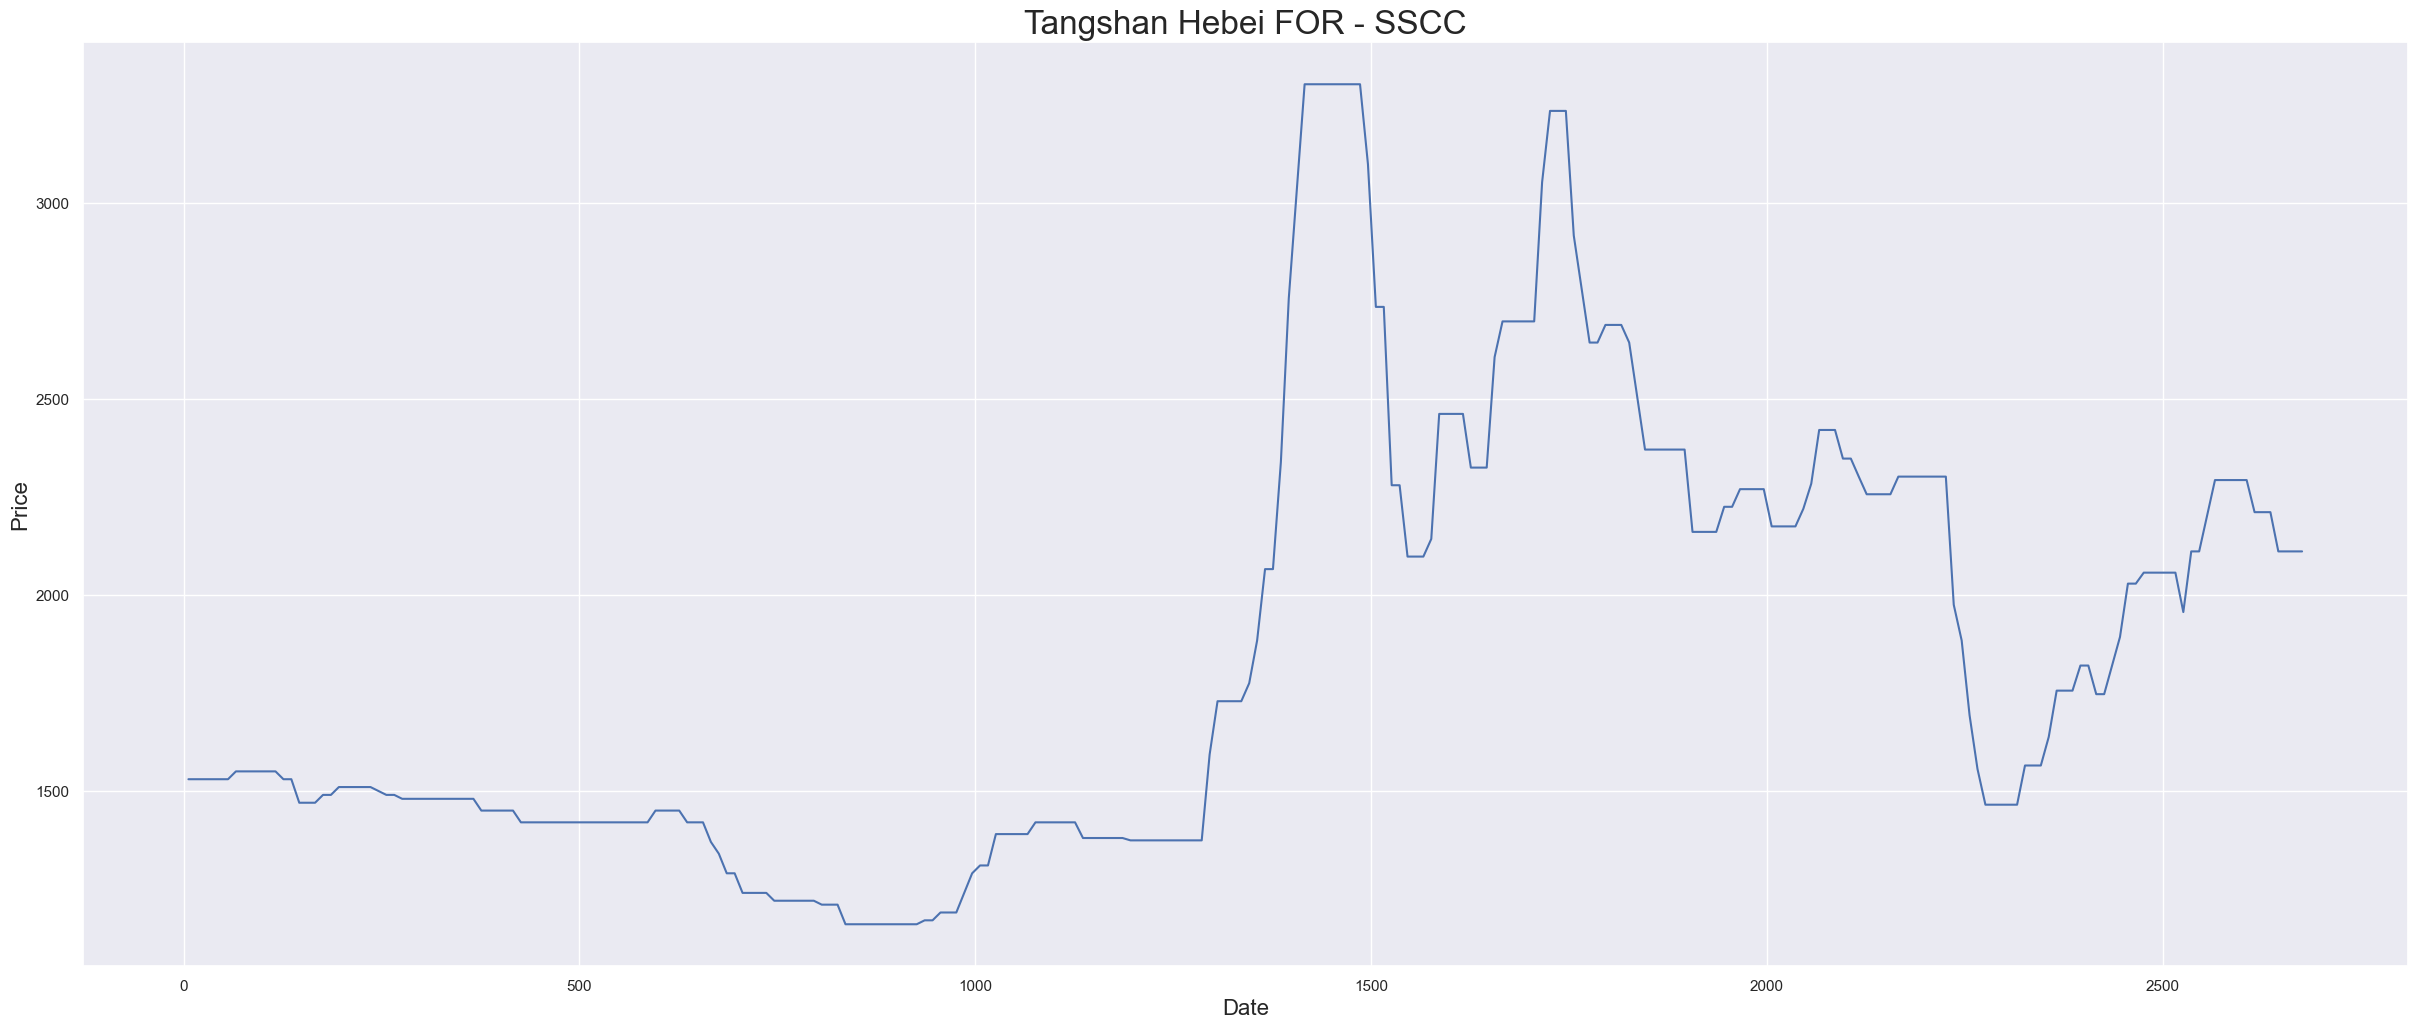

TC


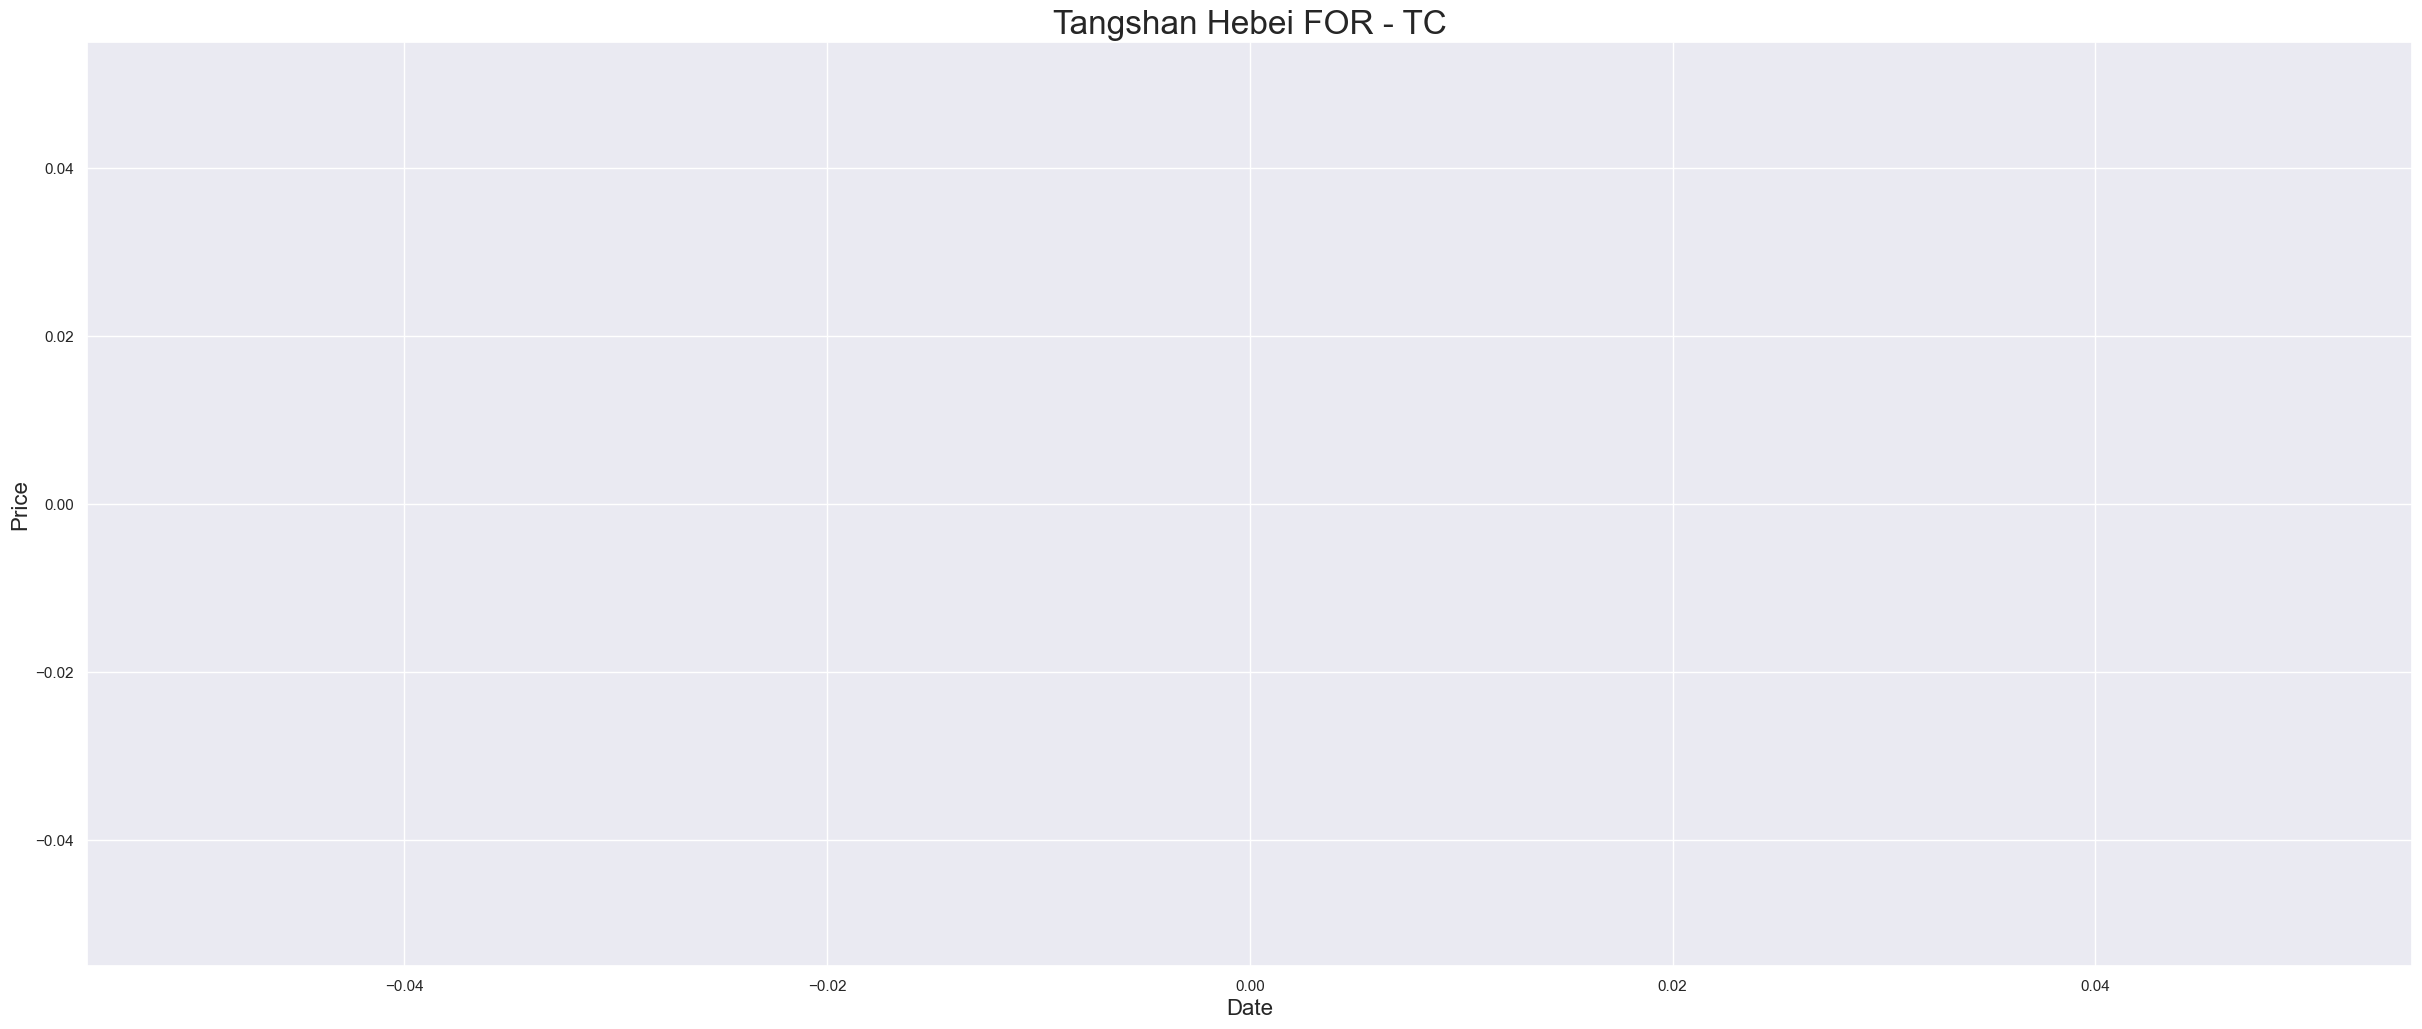

Jingtang Australia EXW
HCC


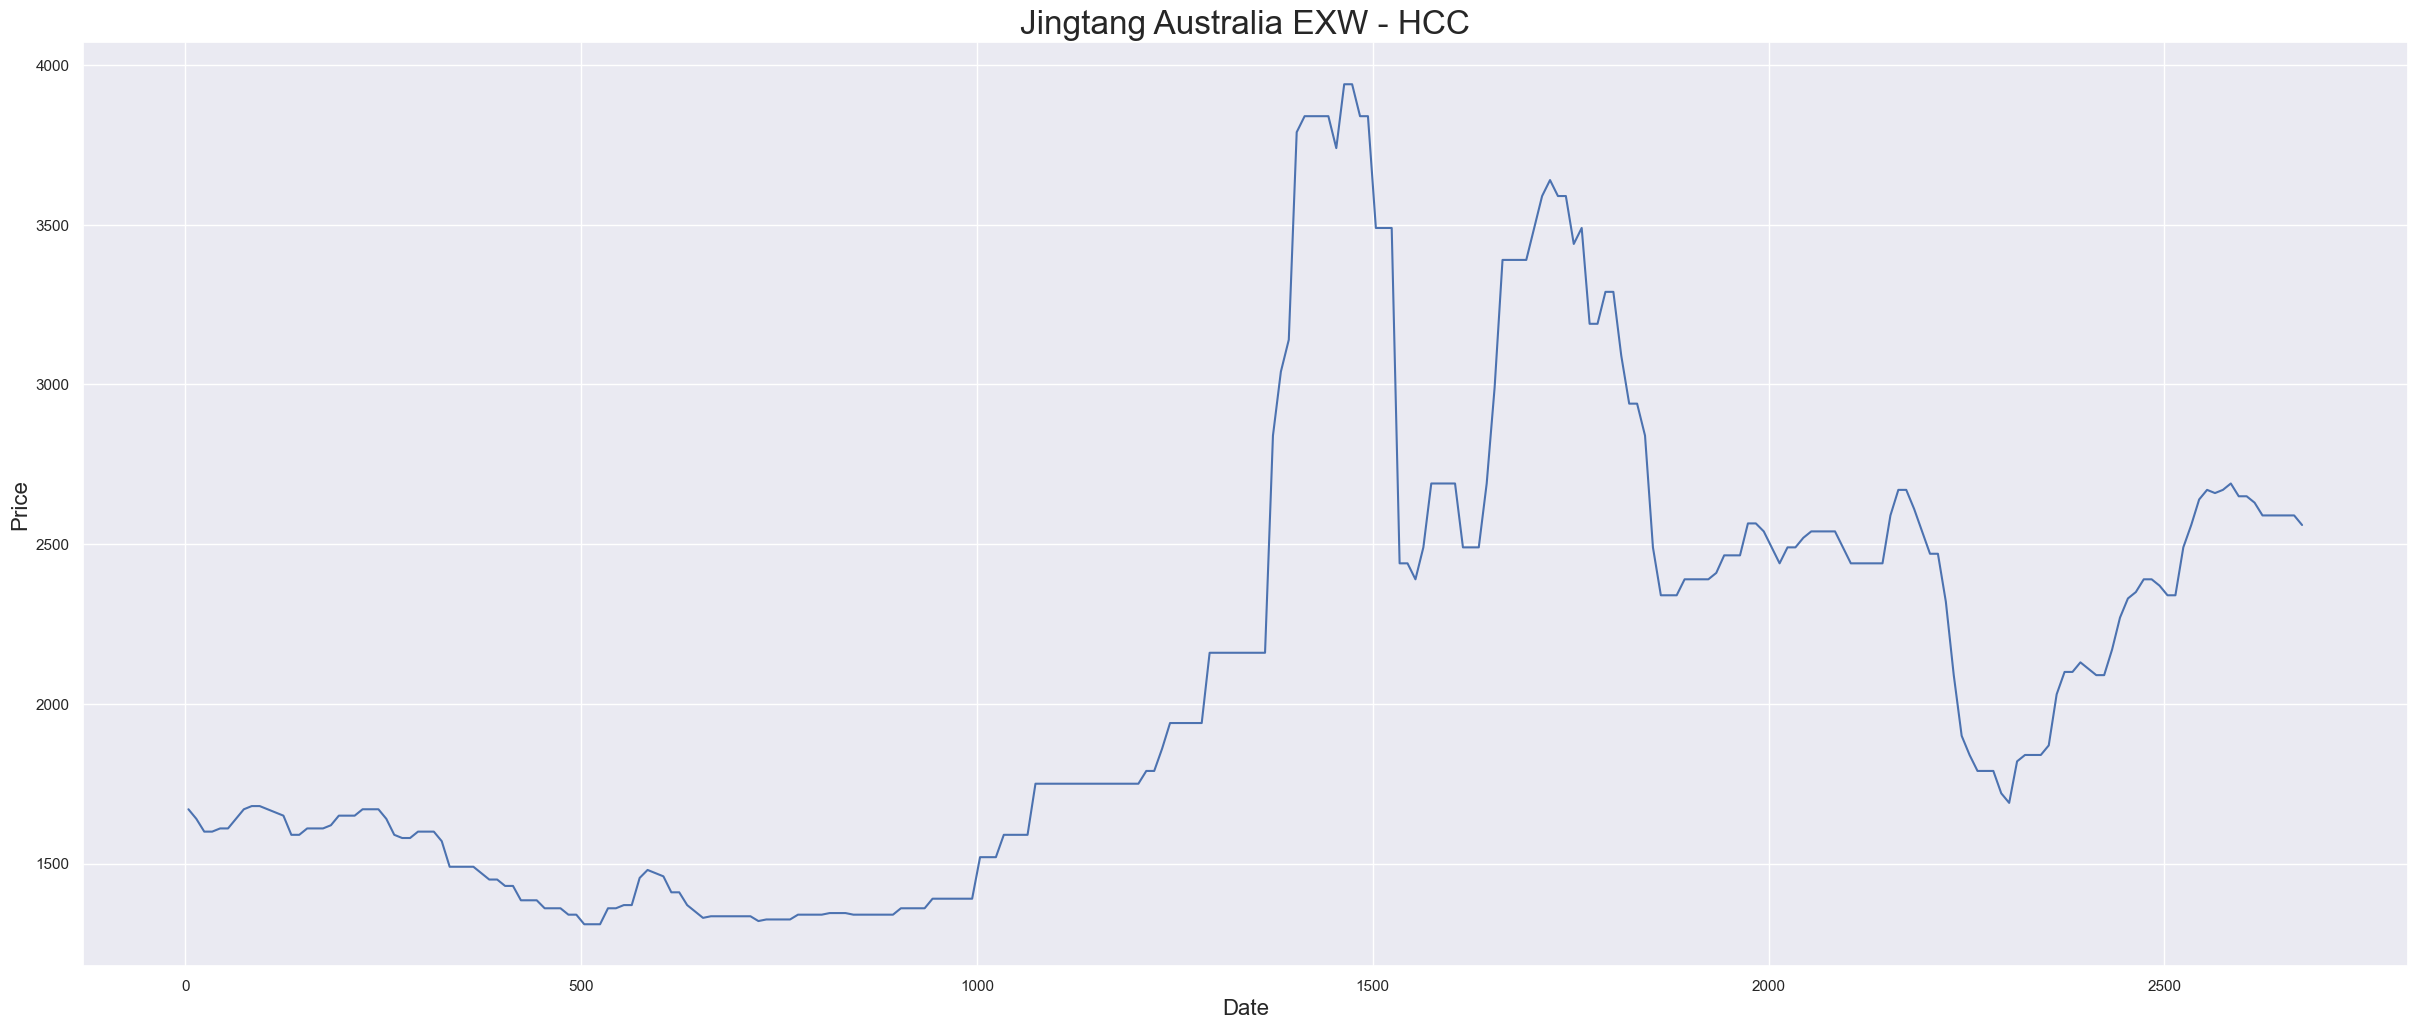

SSCC


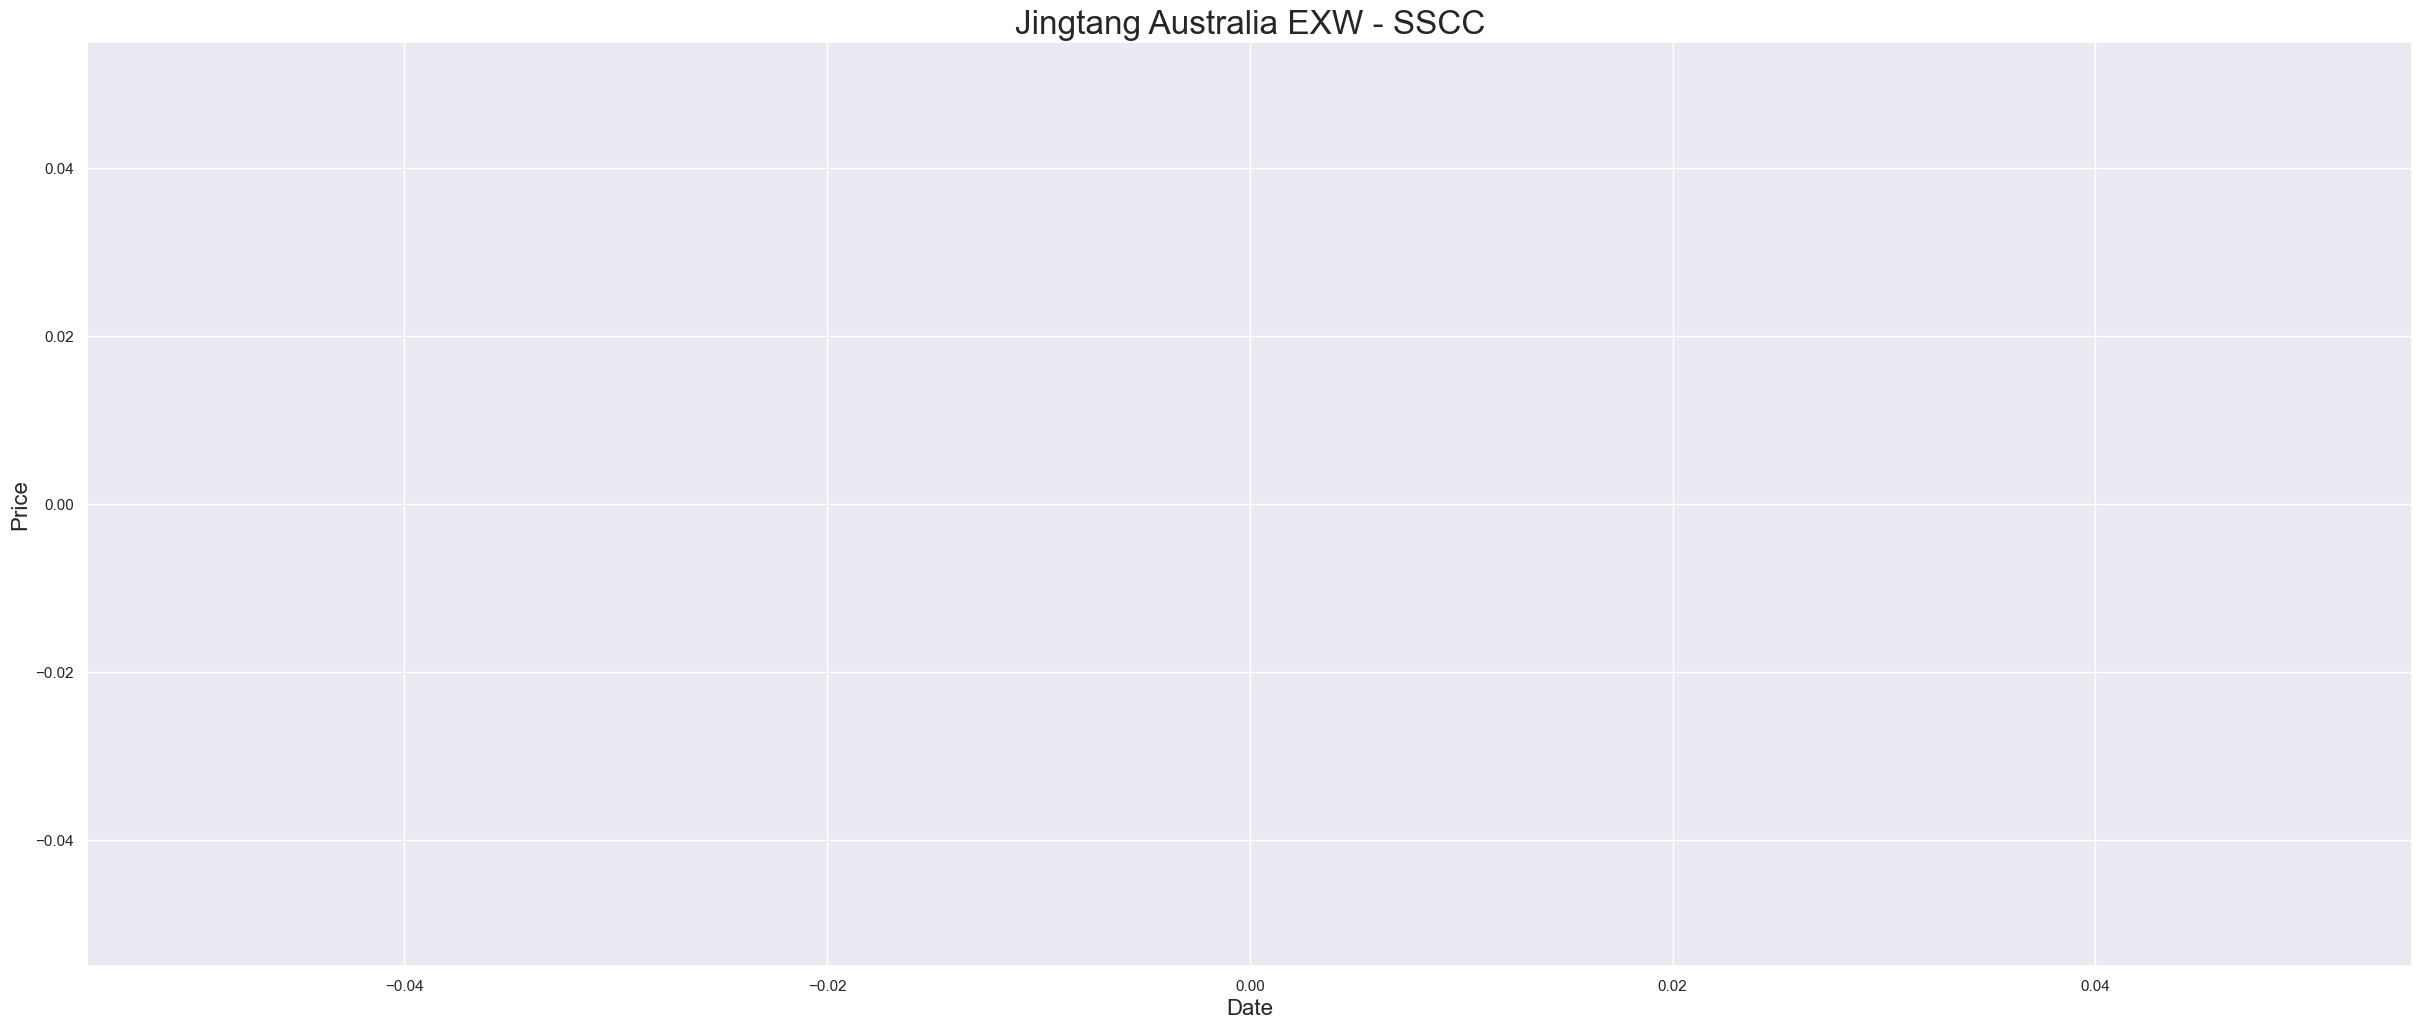

TC


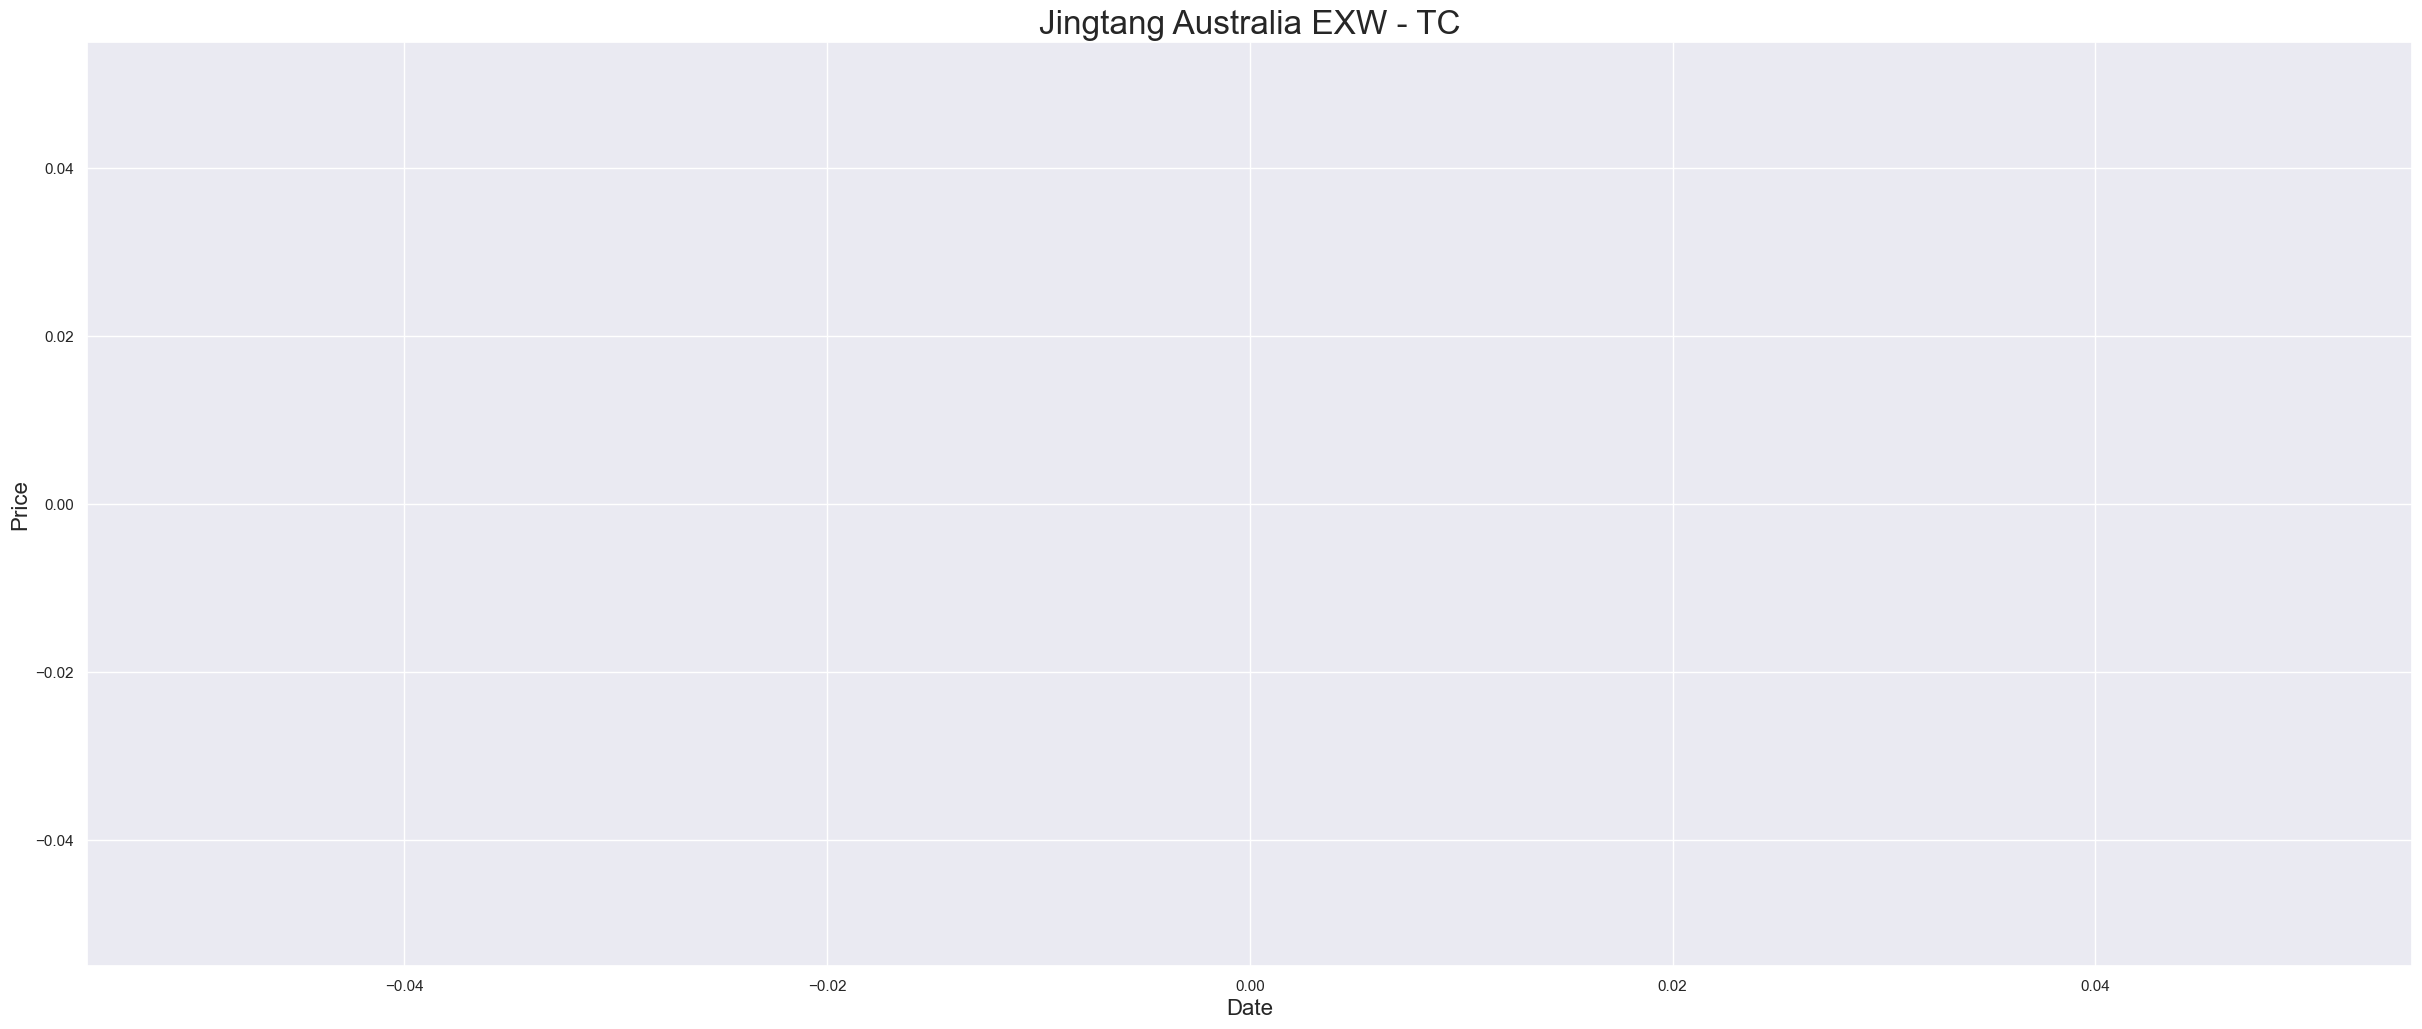

Tianjin Australia EXW
HCC


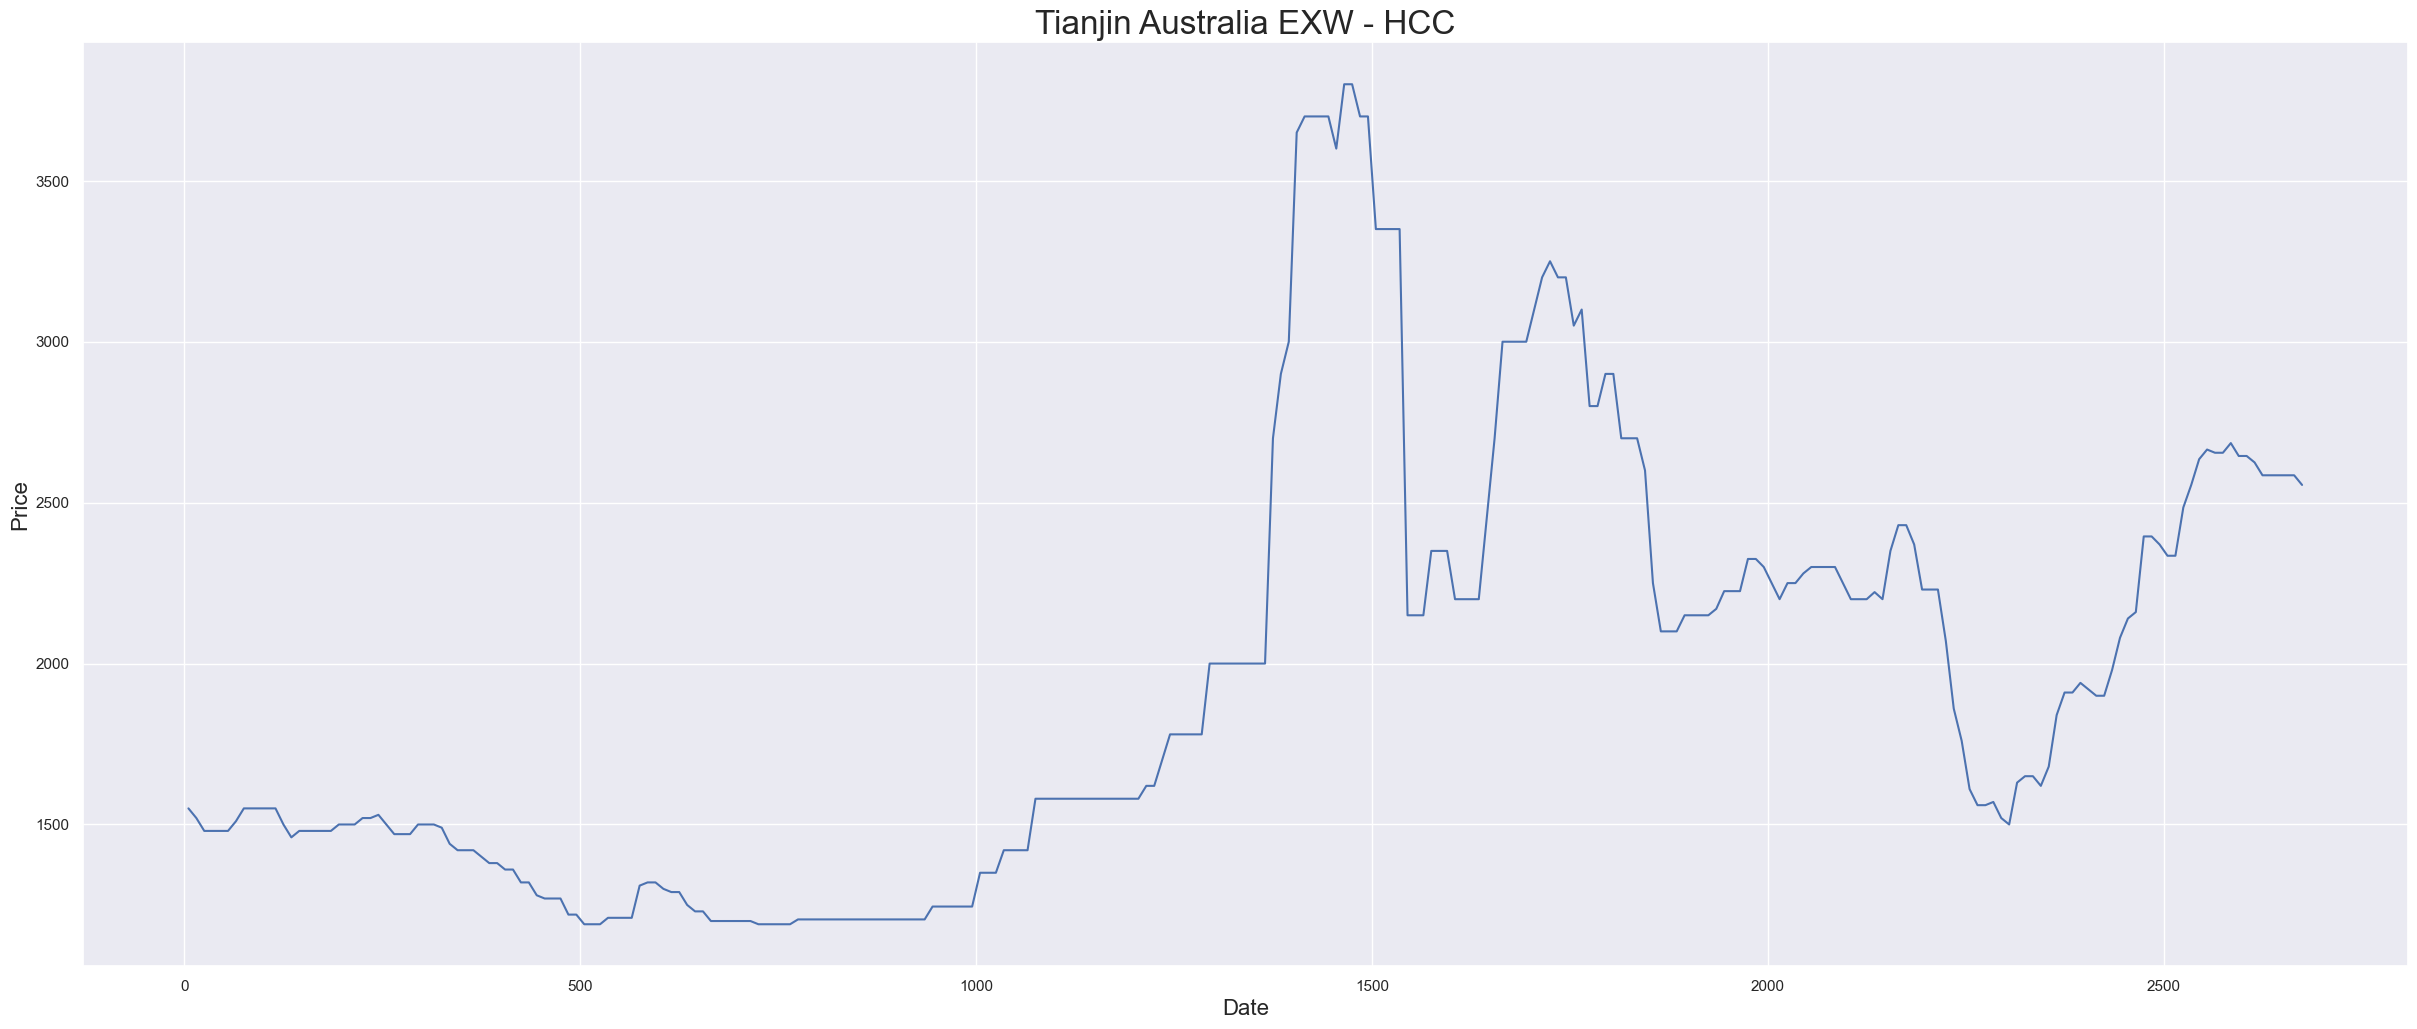

SSCC


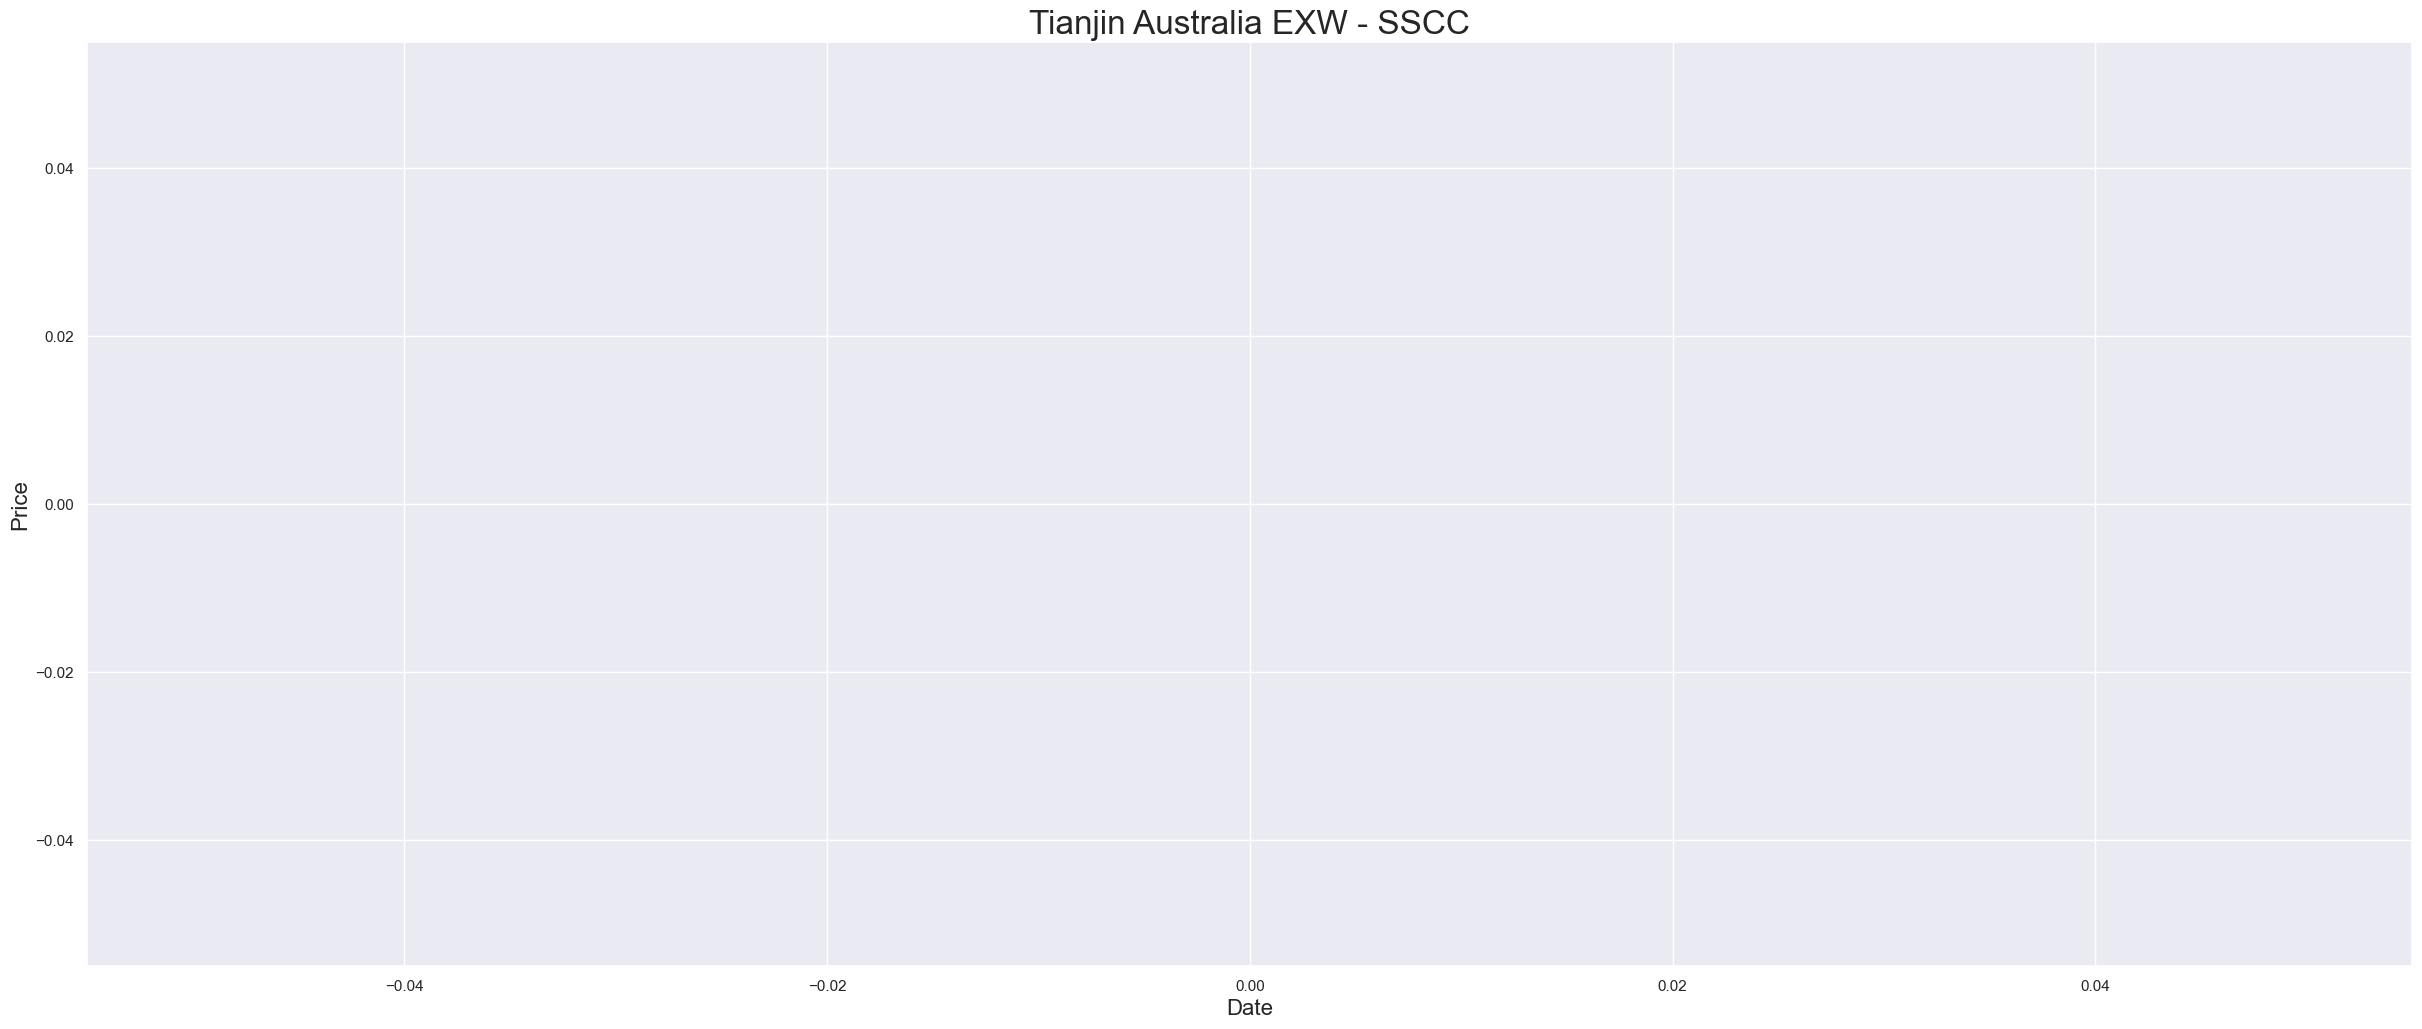

TC


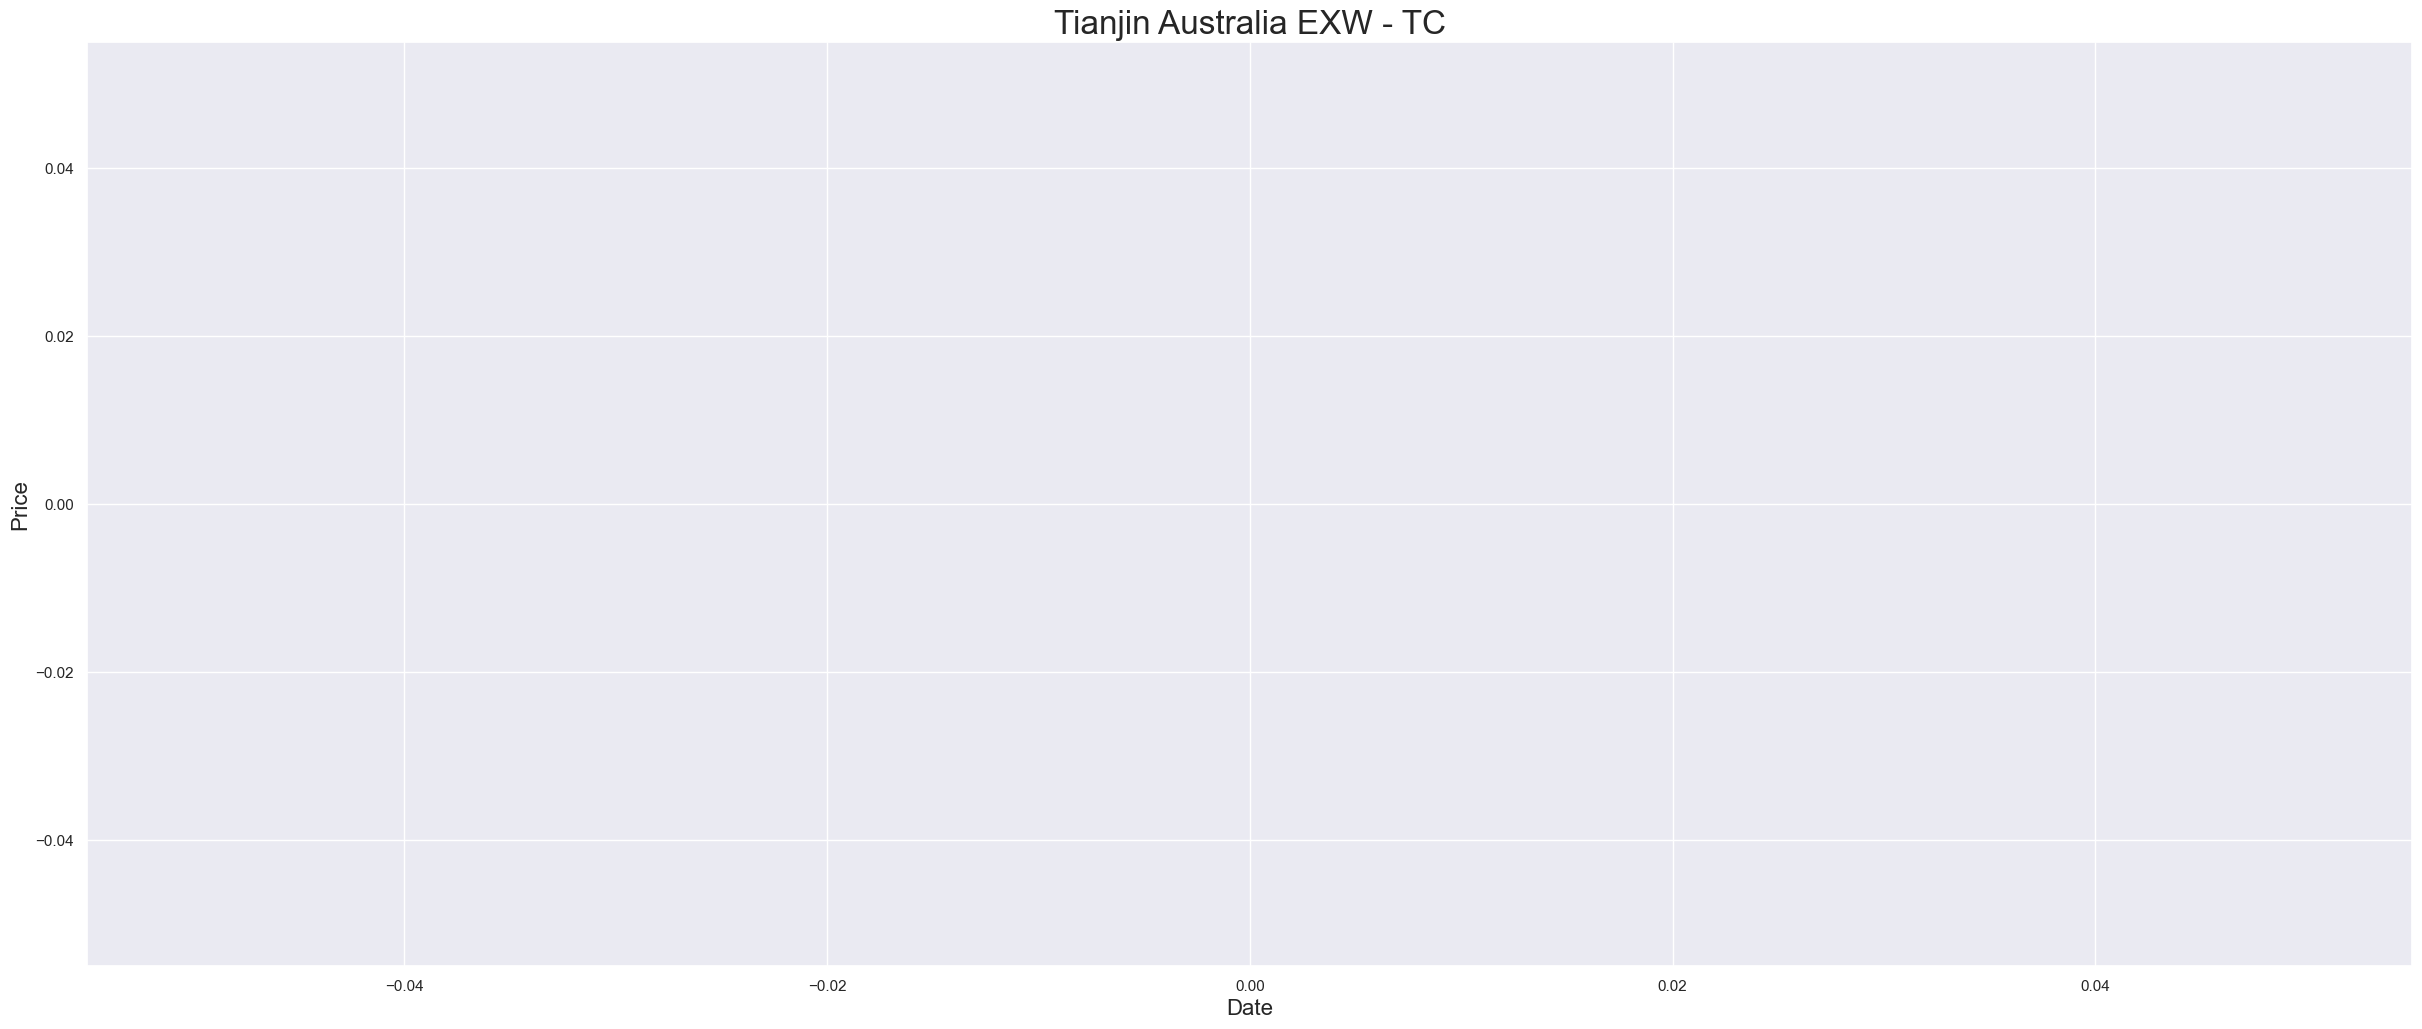

Wuhai EXW
HCC


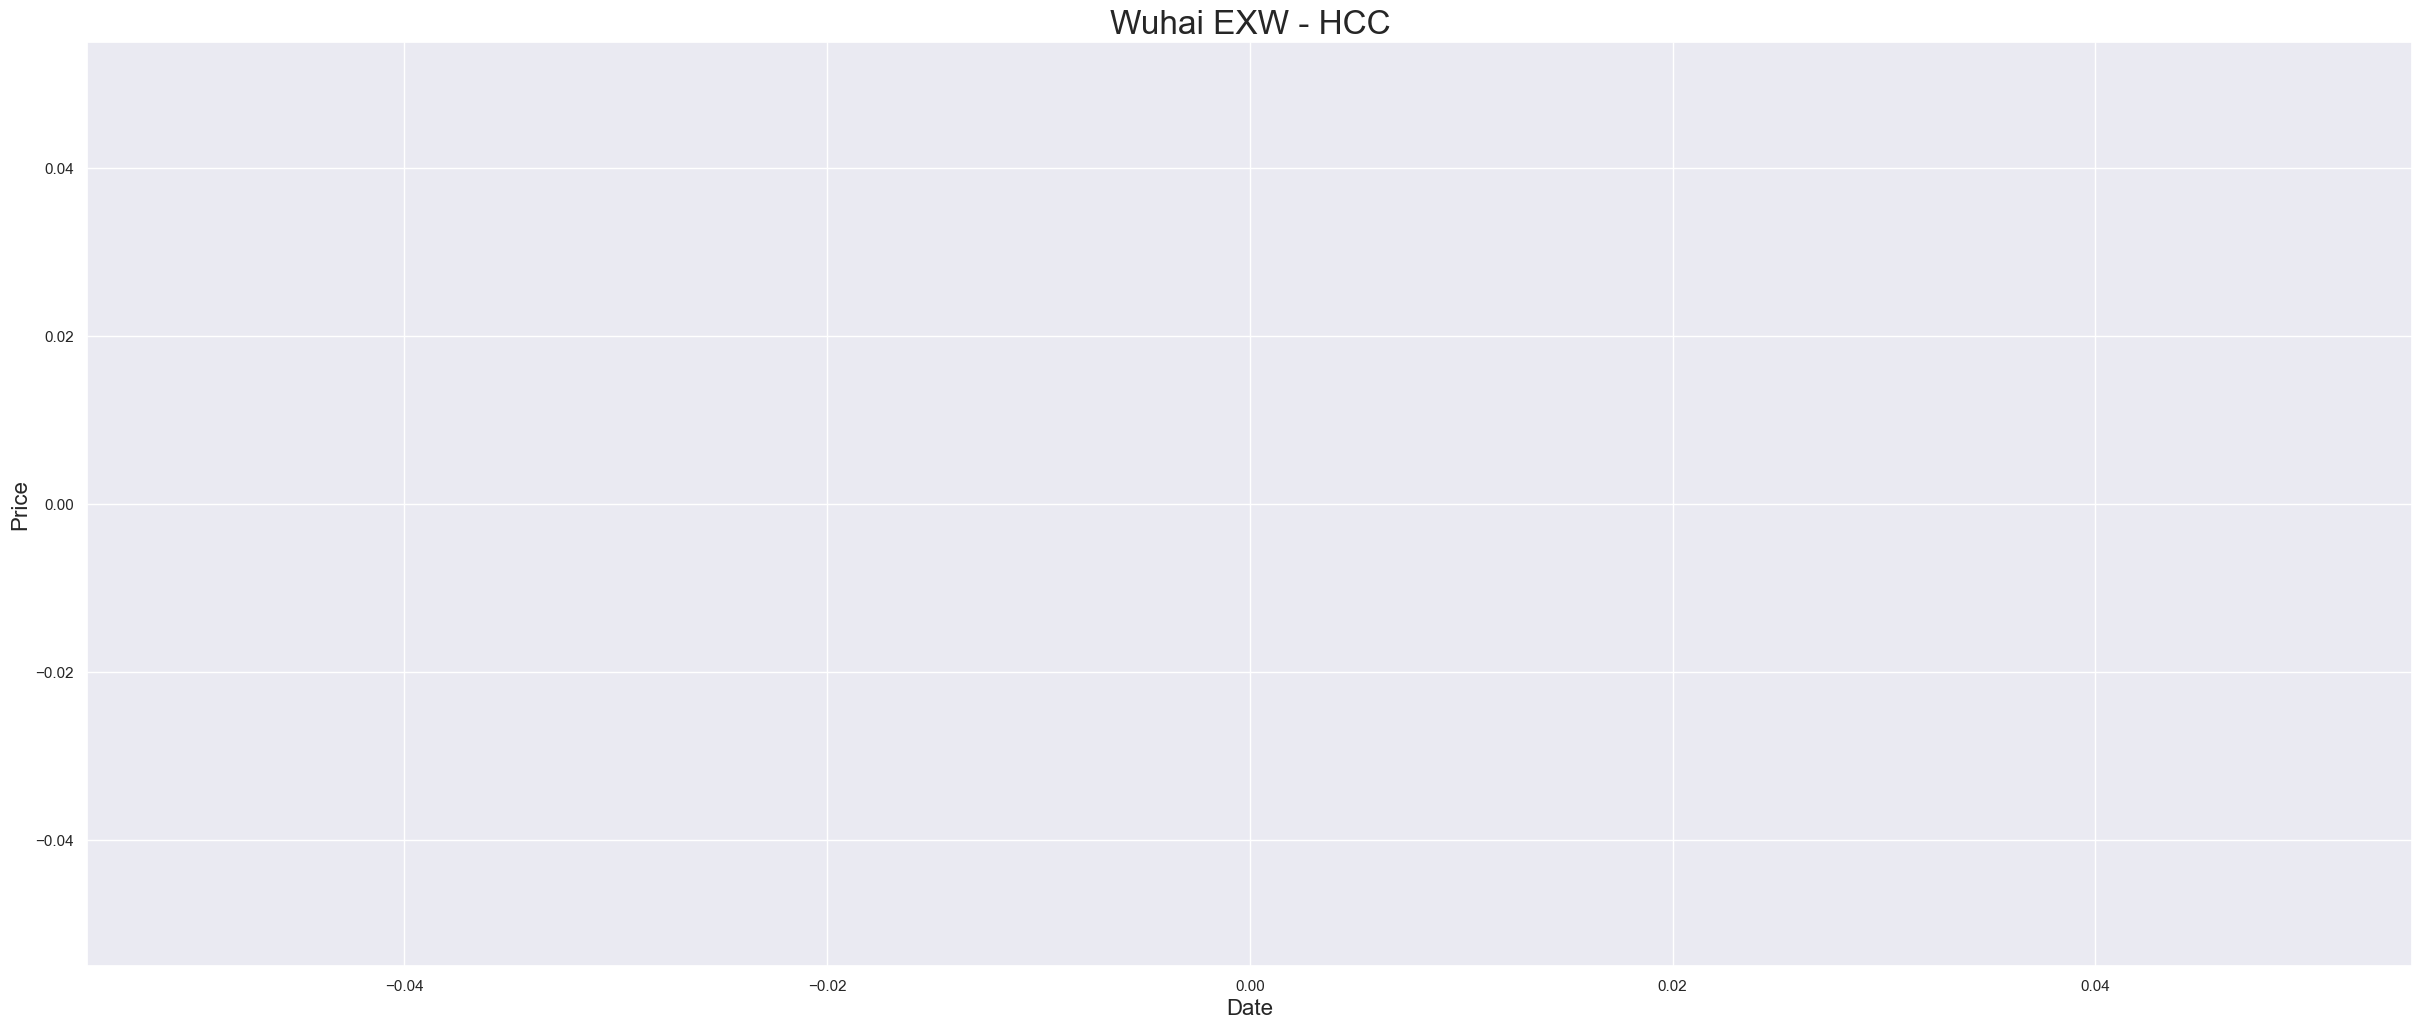

SSCC


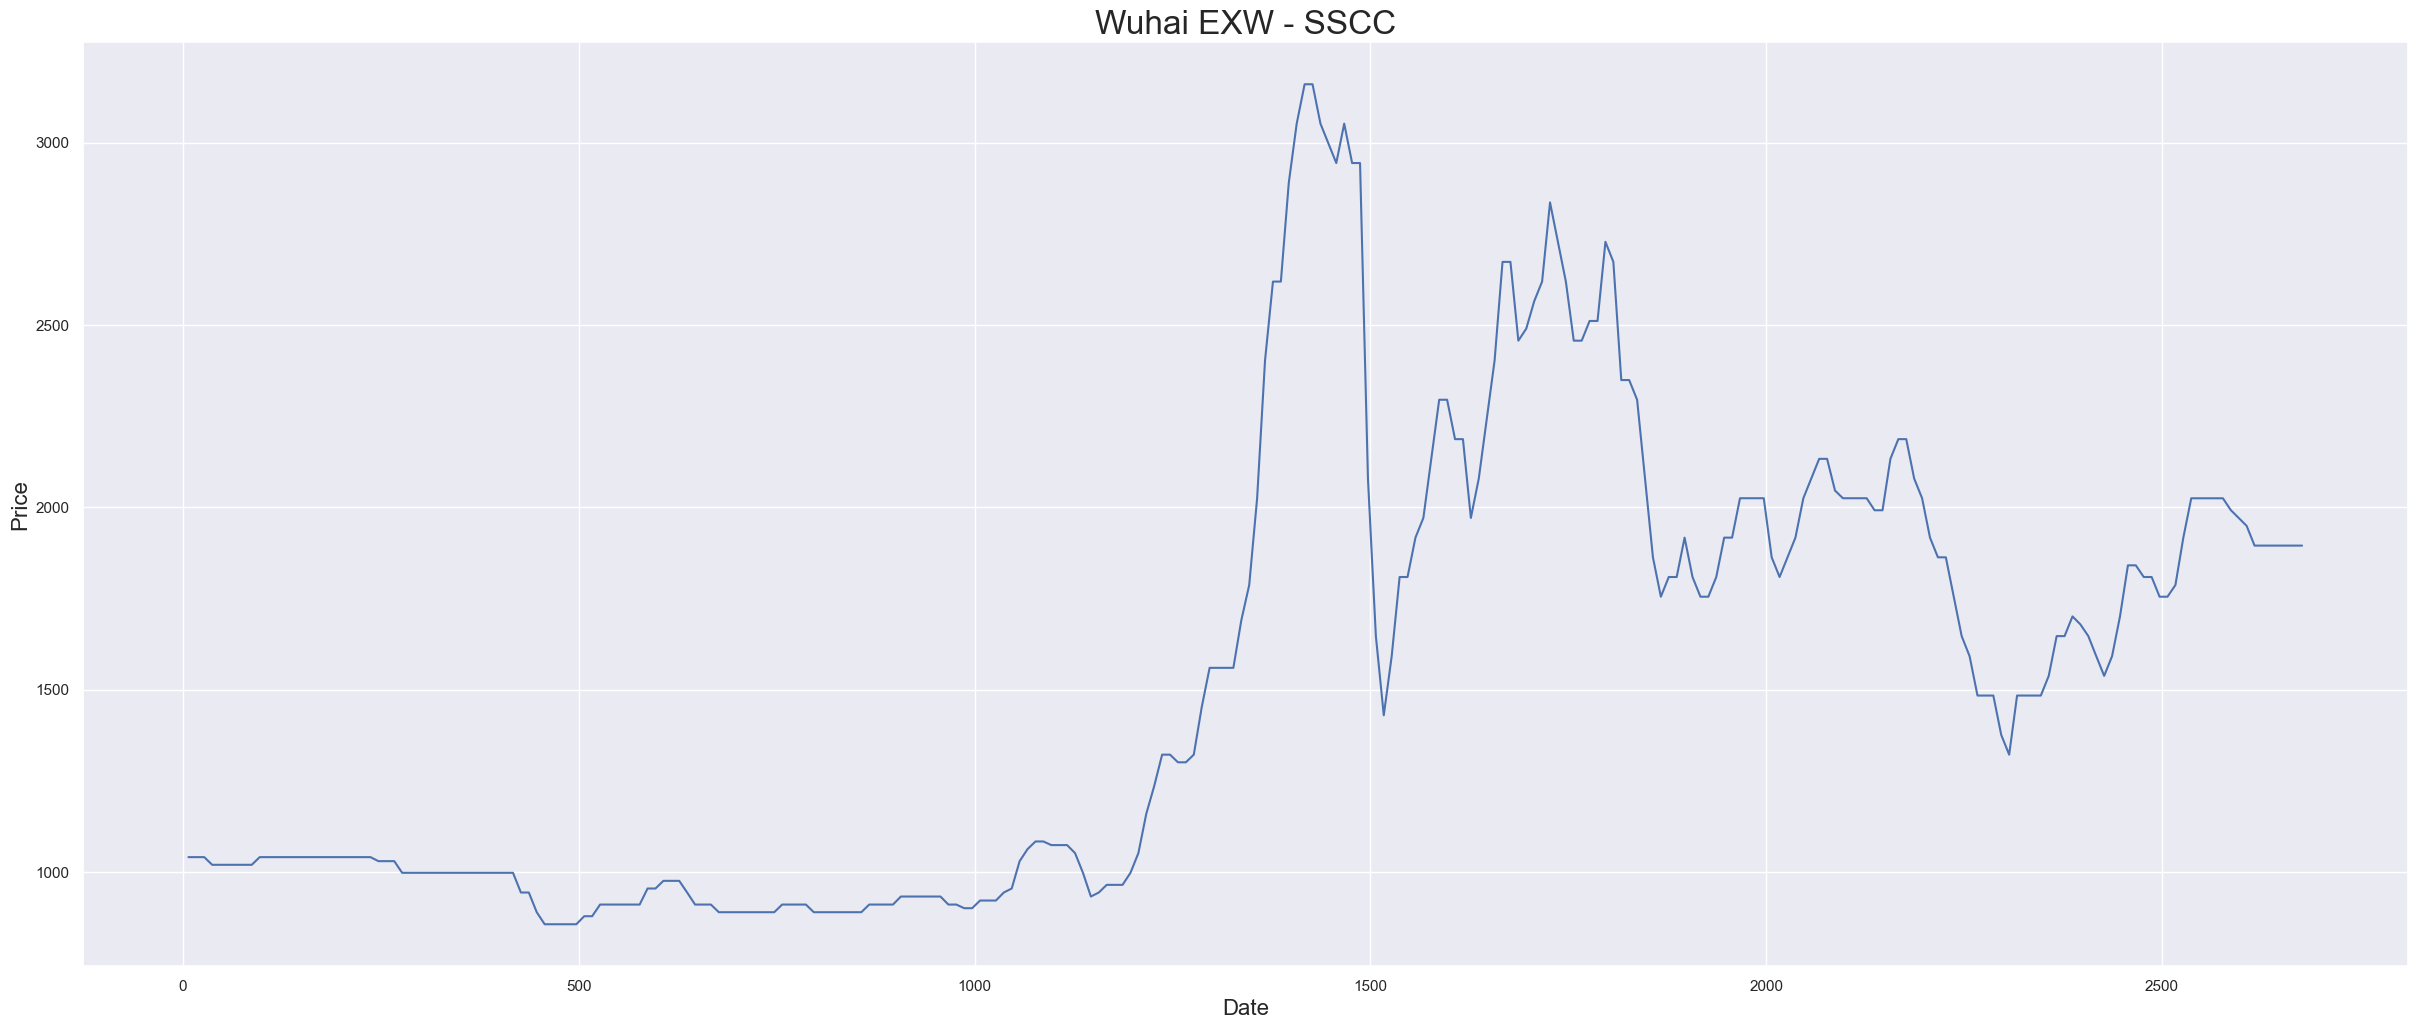

TC


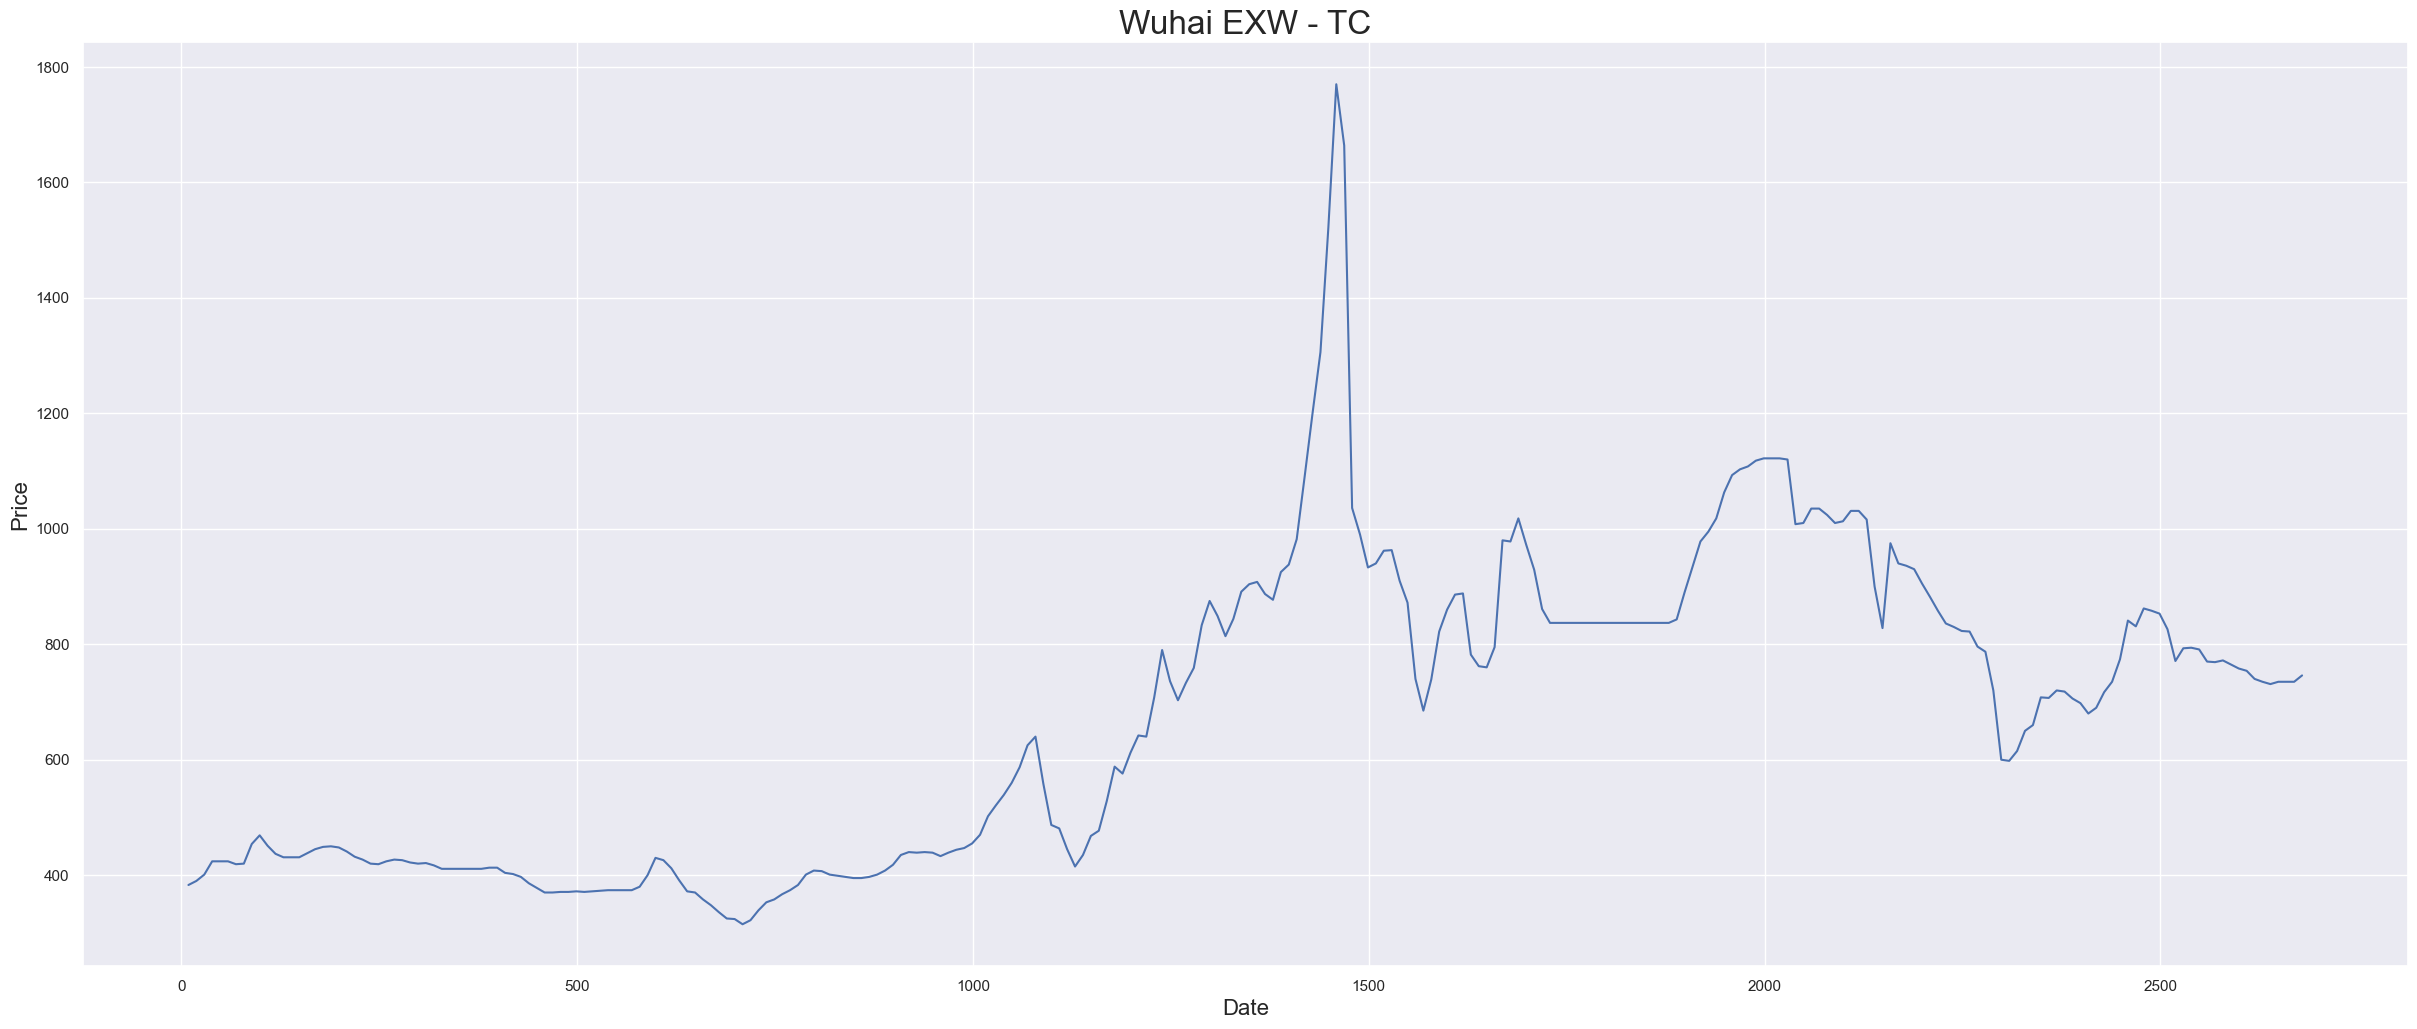

GM DAP
HCC


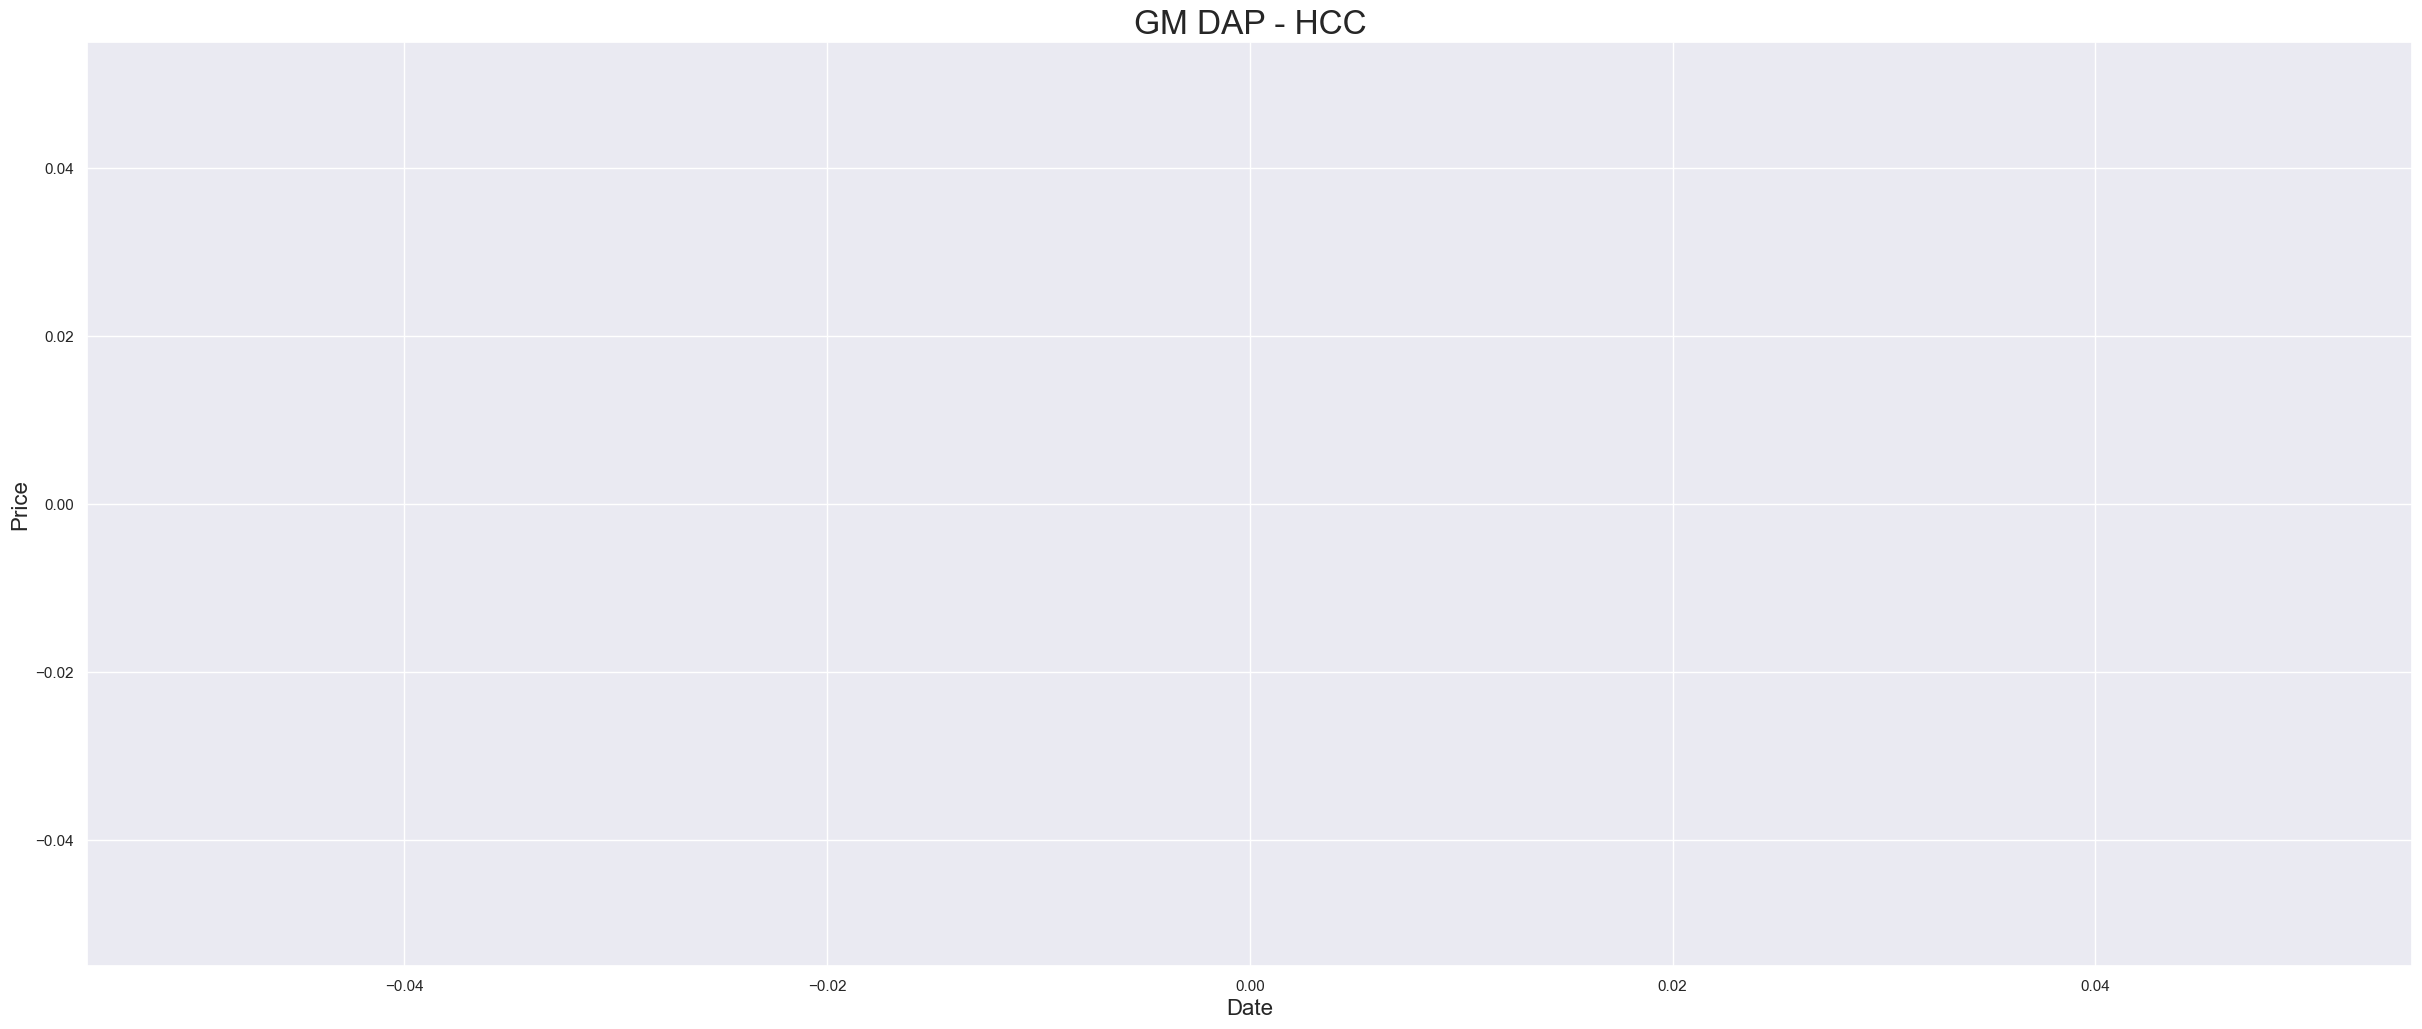

SSCC


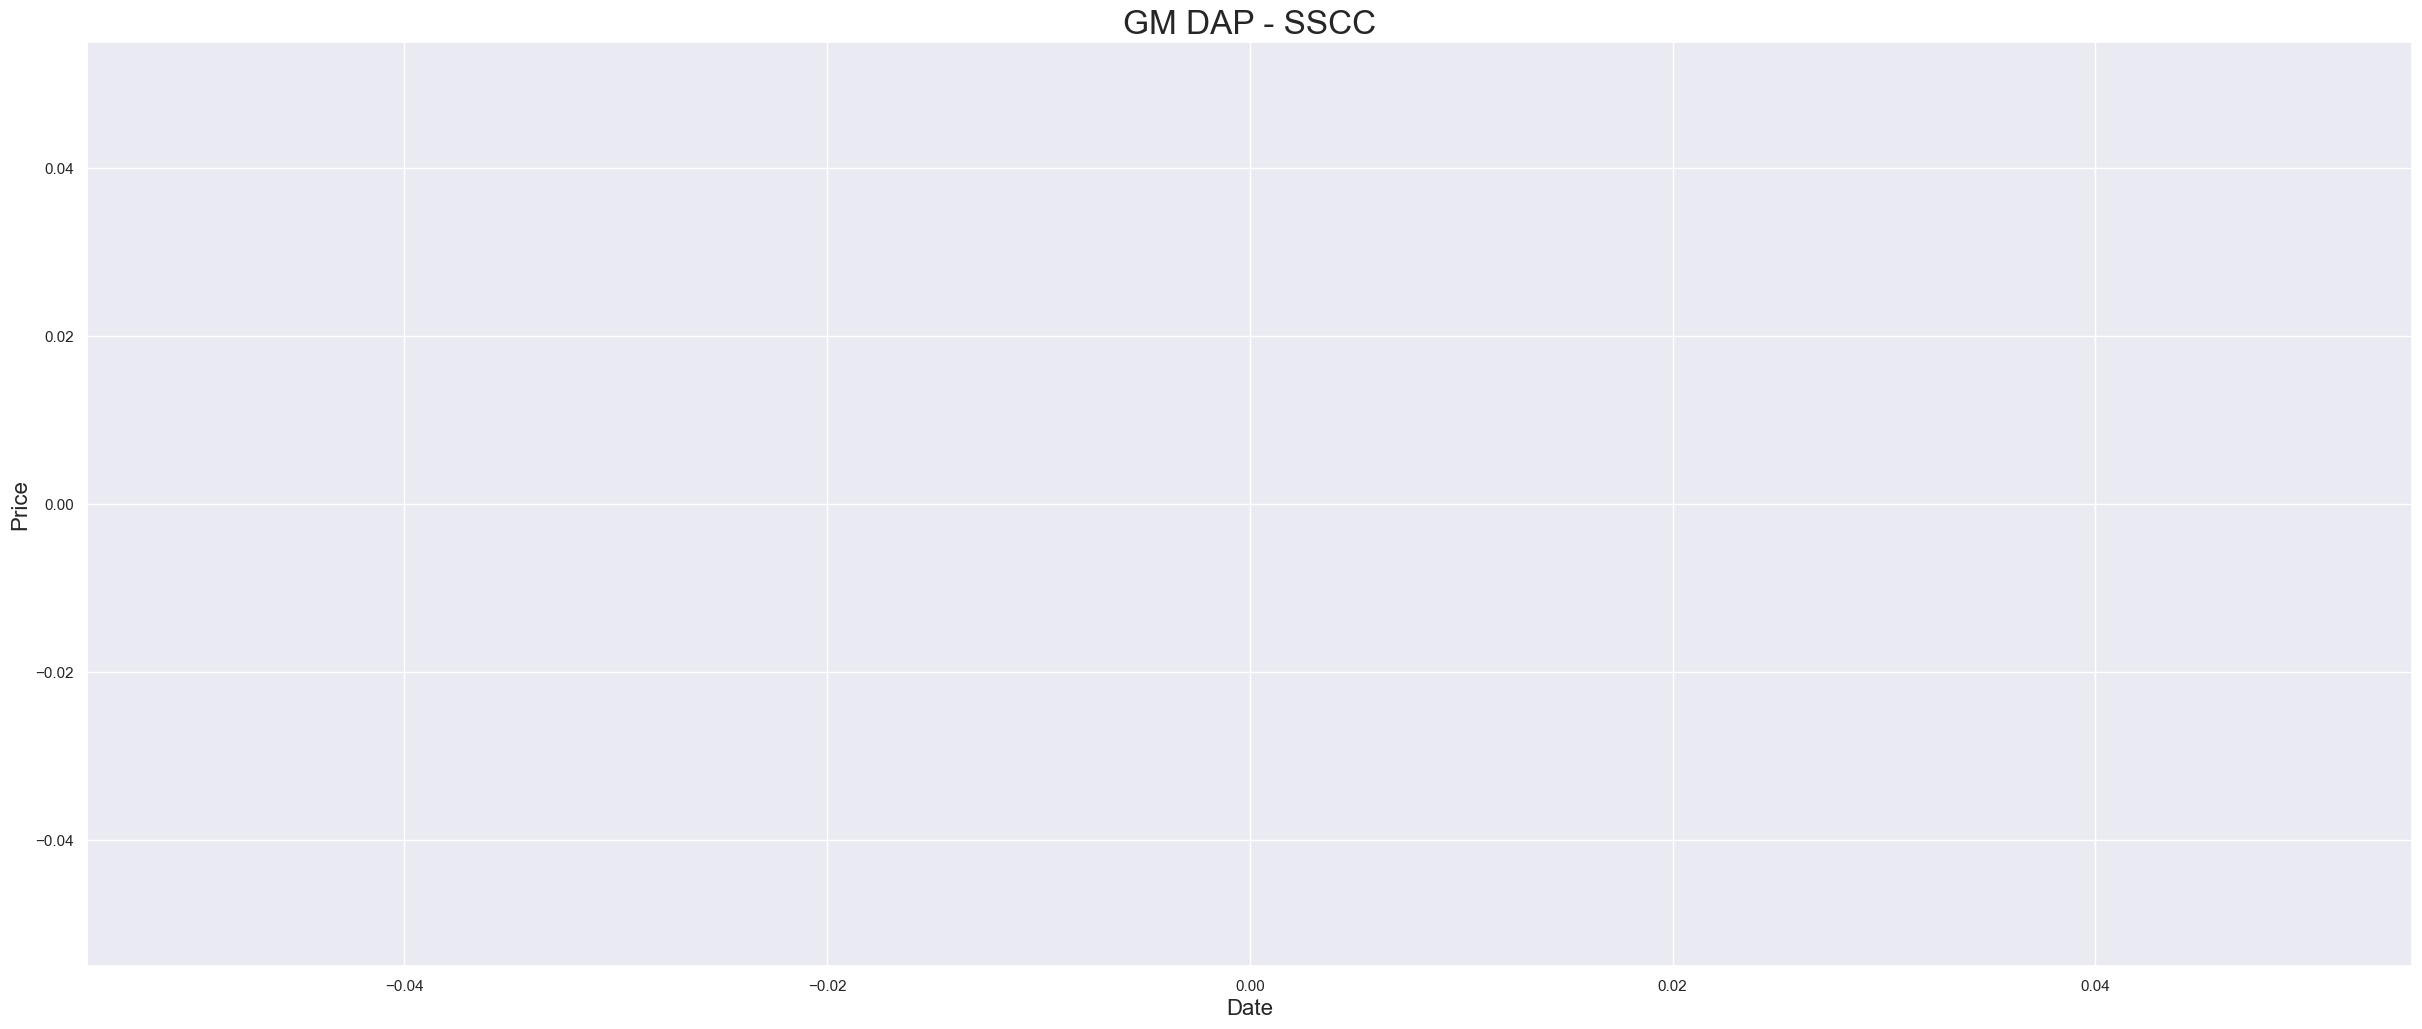

TC


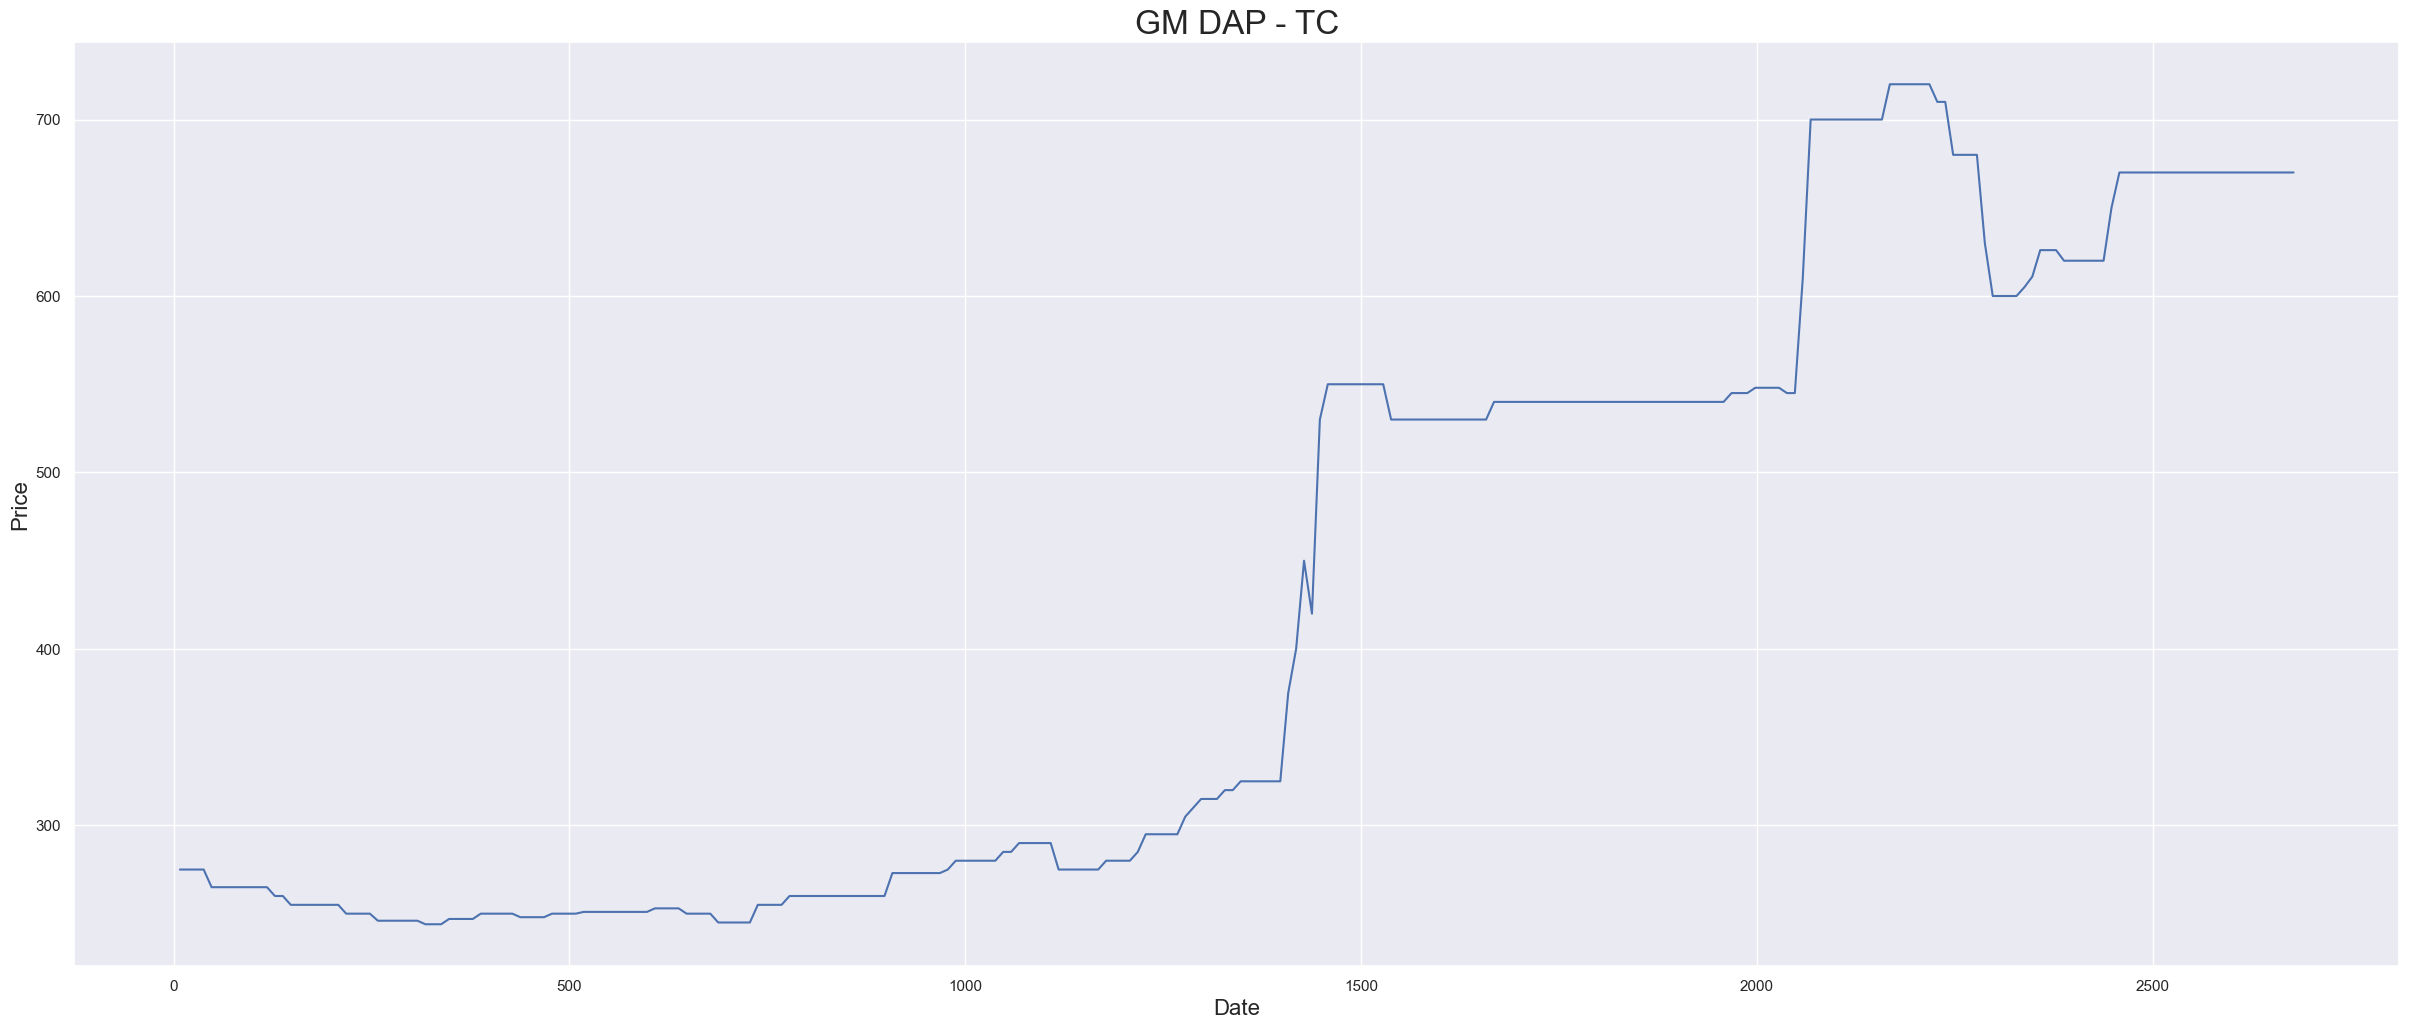

In [40]:
for keys in benchmarks_dict:
  print(keys)
  for coal_type_keys in benchmarks_dict[keys]:
    print(coal_type_keys)
    ax = plot_series(df=benchmarks_dict[keys][coal_type_keys], column='Per _Price', ylabel='Price',
                 title=f'{keys} - {coal_type_keys}', end=24*7*2)
    plt.show()

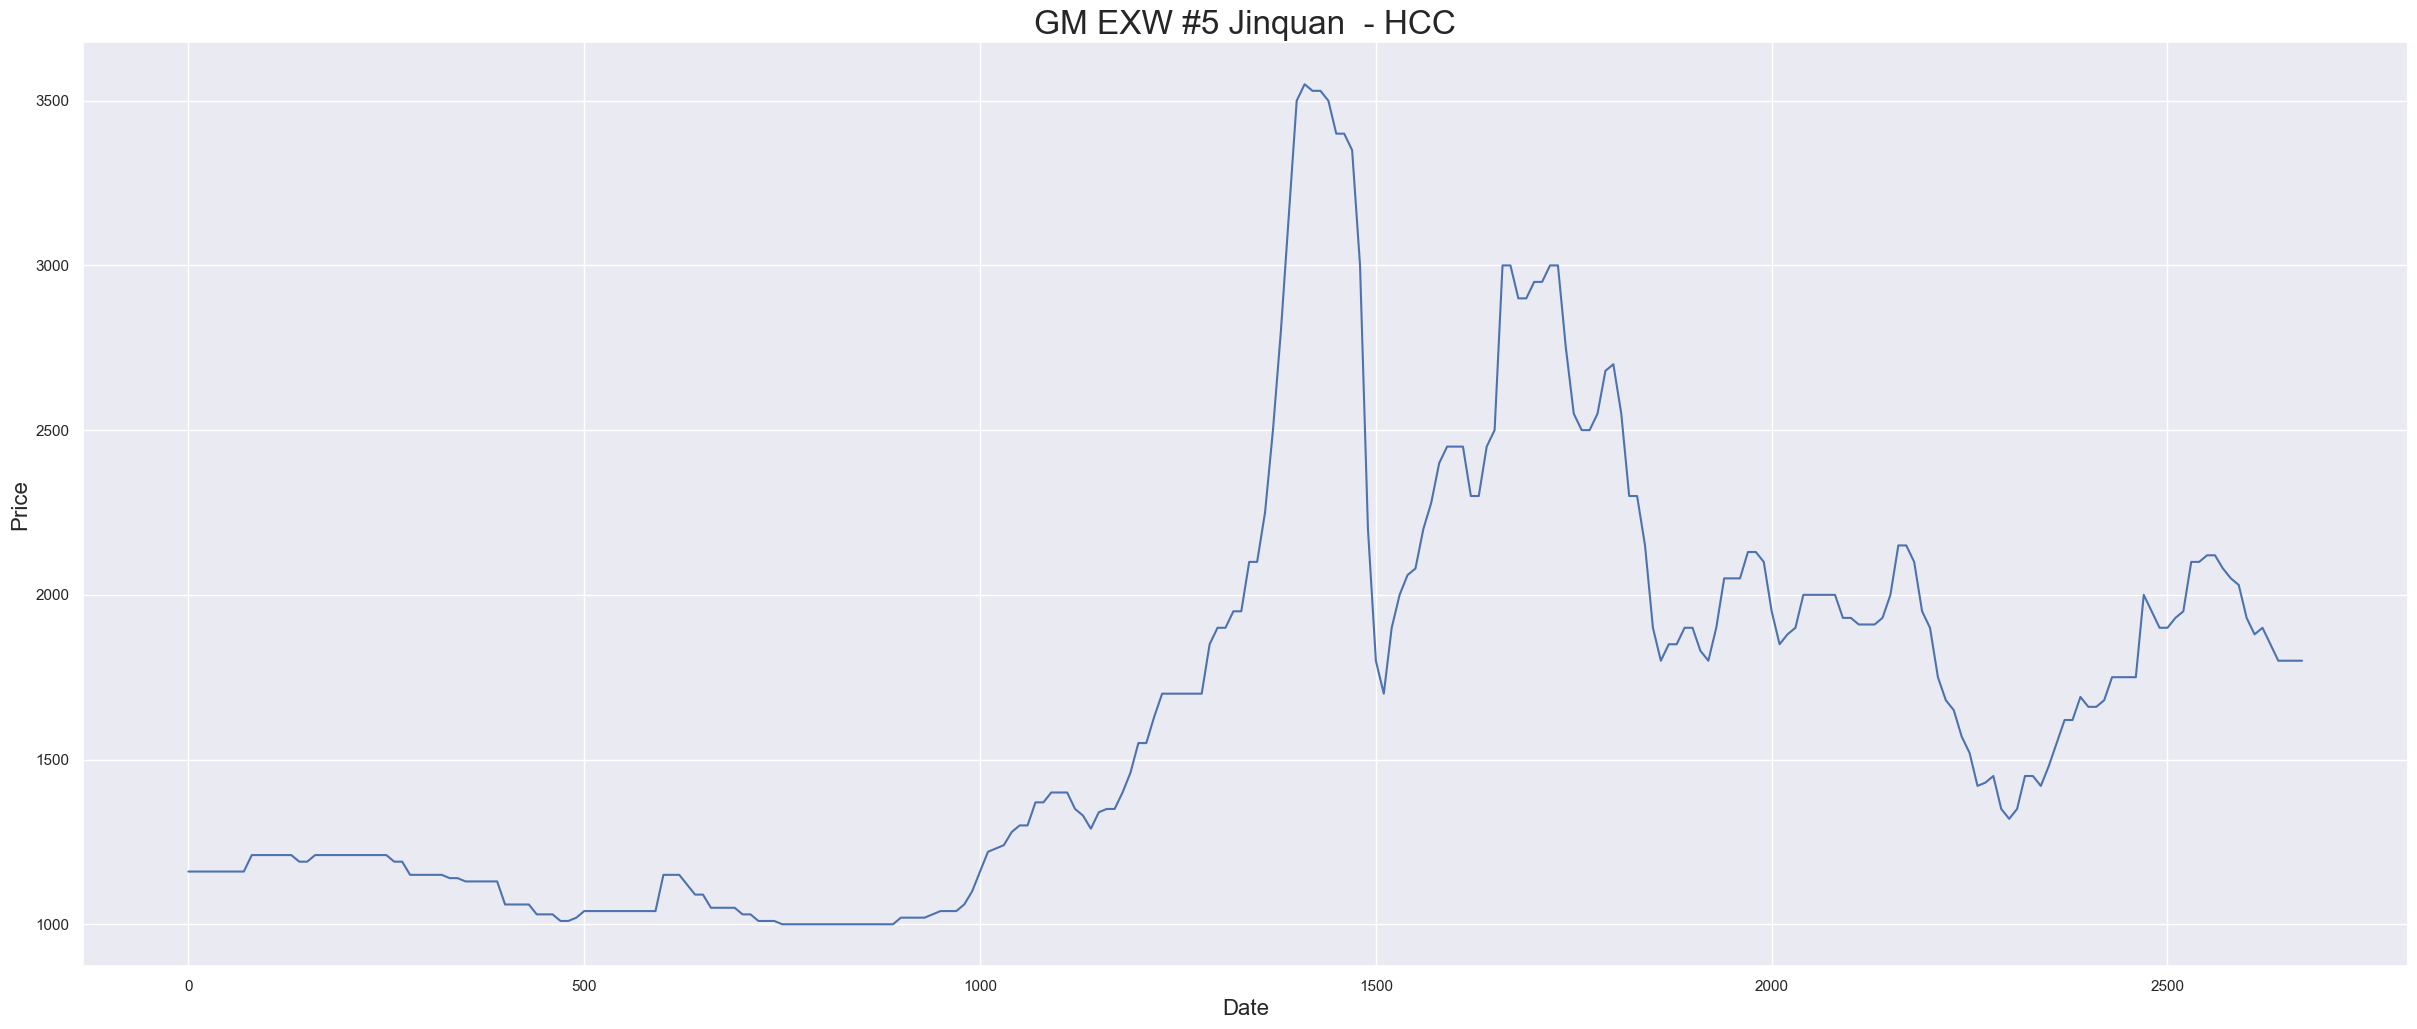

In [41]:
#testing
# GM EXW #5 Jinquan 
# HCC

data_first = benchmarks_dict["GM EXW #5 Jinquan "]["HCC"]

ax = plot_series(df=data_first, column='Per _Price', ylabel='Price',
                 title=f'{"GM EXW #5 Jinquan "} - {"HCC"}', end=24*7*2)
plt.show()

In [42]:
print(len(data_first))

268


In [43]:
# 268 => 200

train_len = 250
train = data_first[0:train_len] # first 120 months as training set
test = data_first[train_len:]

In [44]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Per _Price'][train_len]

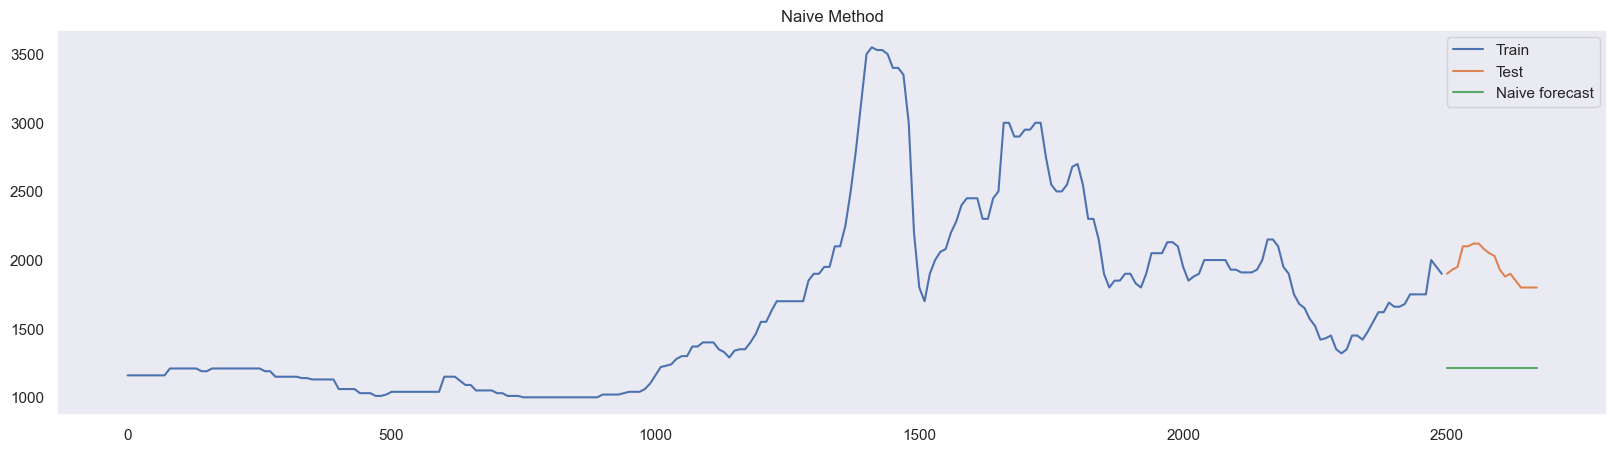

In [45]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['Per _Price'], label='Train')
plt.plot(test['Per _Price'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Per _Price'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Per _Price']-y_hat_naive['naive_forecast'])/test['Per _Price'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,751.4,37.8


In [47]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [51]:
dataframe = benchmarks_dict["GM EXW #5 Jinquan "]["HCC"]
dataset = dataframe.values
dataset = dataset.astype('float32')

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [53]:
#time step to float 
dataframe['Date'] = dataframe['Date'].astype('float32')

TypeError: Cannot cast DatetimeArray to dtype float32

In [52]:
dataframe.head()

,Date,Per _Price
0,2019-01-07 00:00:00+00:00,1160.0
10,2019-01-14 00:00:00+00:00,1160.0
20,2019-01-21 00:00:00+00:00,1160.0
30,2019-01-28 00:00:00+00:00,1160.0
40,2019-02-04 00:00:00+00:00,1160.0


In [50]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

TypeError: float() argument must be a string or a real number, not 'Timestamp'